# Part A
You should only need to run this once, after that can simply load in the saved images as done in part B.

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps


Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os
import sys
# import javabridge
# import bioformats

script_dir = os.path.dirname(os.path.realpath("__file__"))
data_dir = os.path.abspath(os.path.join(script_dir, "..", "data_processed"))
# dir_path = os.path.abspath(
#     os.path.join(
#         script_dir,
#         "..",
#         "..",
#         "data_raw_big/Xenium_V1_FF_Mouse_Brain_MultiSection_1_outs",
#     )
# )
file_path = os.path.join(data_dir, "morphology_focus.tif")

### Setup

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps

Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os
import re

In [18]:
DATA_DIRECTORY = data_dir
CELL_IMAGES = os.path.join(DATA_DIRECTORY, "cell_images_py")
SIZE = (50, 50)

## Loading in and displaying images

In [19]:
def get_cluster_images(cluster: int, size=(None, None)):
    DIR = os.path.join(CELL_IMAGES, f"cluster_{cluster}")
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    files.sort()
    return [
        Image.open(file).convert("L")
        if None in size
        else Image.open(file).convert("L").resize(size)
        for file in files
    ]

In [20]:
# cluster_A_files = os.path.join(CELL_IMAGES, os.listdir(os.path.join(CELL_IMAGES, 'cluster_8')))
cluster_A_files = [
    os.path.join(os.path.join(CELL_IMAGES, "cluster_8"), file)
    for file in os.listdir(os.path.join(CELL_IMAGES, "cluster_8"))
]
cluster_B_files = [
    os.path.join(os.path.join(CELL_IMAGES, "cluster_13"), file)
    for file in os.listdir(os.path.join(CELL_IMAGES, "cluster_13"))
]

In [21]:
cluster_A_images = get_cluster_images(8)
cluster_B_images = get_cluster_images(13)
cluster_A_images_resized = get_cluster_images(8, size=SIZE)
cluster_B_images_resized = get_cluster_images(13, size=SIZE)

In [22]:
def display_images_in_grid(images, ncols=3, cmap=None):
    nrows = (len(images) + ncols - 1) // ncols
    fig_height = (
        nrows * 1
    )  # Adjust the multiplier as needed to control spacing between rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, fig_height))

    for ax in axes.flat:
        ax.axis("off")

    for i, image in enumerate(images):
        ax = axes[i // ncols, i % ncols]
        if not cmap:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap=cmap)

    plt.subplots_adjust(wspace=0.01, hspace=0.03)  # Adjust spacing between subplots
    plt.show()


# display_images_in_grid(cluster_A_images_resized, ncols=10, cmap="gray")

## Cell boundary and masking

### Setup

In [23]:
from shapely.geometry import Polygon

# import rasterio
# from rasterio.features import geometry_mask
from skimage.draw import polygon2mask

In [24]:
cell_boundaries_raw = pd.read_csv("../data_processed/cell_boundaries.csv.gz")


def get_cluster_cell_ids(cluster: int):
    DIR = os.path.join(CELL_IMAGES, f"cluster_{cluster}")
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    pattern = r"cell_(\d+)\.png"
    return [int(re.search(pattern, file).group(1)) for file in files]


cluster_A_cell_ids = get_cluster_cell_ids(8)
cluster_B_cell_ids = get_cluster_cell_ids(13)

### Masking one cell

In [25]:
cell_boundaries = cell_boundaries_raw.loc[
    cell_boundaries_raw["cell_id"].isin(cluster_A_cell_ids + cluster_B_cell_ids)
]

In [26]:
def get_masked_image(
    image: Image, cell_id: int, cell_boundaries: pd.core.frame.DataFrame
):
    height, width = np.array(image).shape
    cell_boundary = cell_boundaries[cell_boundaries["cell_id"] == cell_id].copy()
    cell_boundary["vertex_x_scaled"] = 1 + (
        (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min()) * scaling_factor
    )
    cell_boundary["vertex_y_scaled"] = 1 + (
        (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min()) * scaling_factor
    )
    polygon = np.array(
        list(zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"]))
    )
    mask = polygon2mask((height, width), polygon)
    masked_image = np.ma.masked_array(np.copy(img_A), np.invert(mask), fill_value=0)
    return masked_image

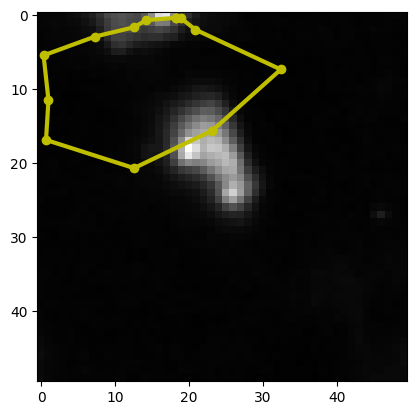

In [27]:
index = 0

cell_boundary = cell_boundaries[
    cell_boundaries["cell_id"] == cluster_A_cell_ids[index]
].copy()
img_A = cluster_A_images[index].convert("L")
img_A_resized = cluster_A_images_resized[index].convert("L")

# Calculate scaling factor
scaling_factor = 1 / 0.22
height, width = np.array(img_A).shape

# Calculate scaled x and y coordinates
cell_boundary["vertex_x_scaled"] = (
    (
        1
        + (
            (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min())
            * scaling_factor
        )
    )
    * 50
    / width
)
cell_boundary["vertex_y_scaled"] = (
    (
        1
        + (
            (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min())
            * scaling_factor
        )
    )
    * 50
    / height
)

# Visualize the image
plt.clf()
plt.close()
plt.imshow(img_A_resized, cmap="gray")
plt.plot(
    cell_boundary["vertex_x_scaled"],
    cell_boundary["vertex_y_scaled"],
    "y-o",
    linewidth=3,
)
plt.show()

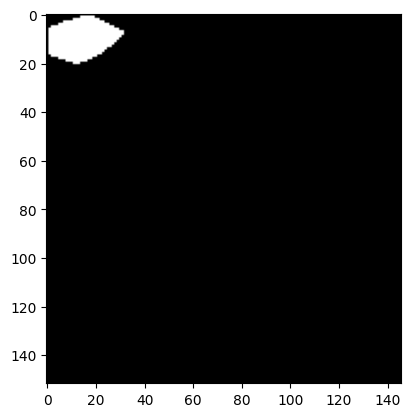

In [28]:
height, width = np.array(img_A.convert("L")).shape
polygon = np.array(
    list(zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"]))
)
mask = polygon2mask((height, width), polygon)
masked_image = np.ma.masked_array(np.copy(img_A), np.invert(mask), fill_value=0)

# Display the masked image
# result = np.where(masked_image.mask, 0, masked_image)  # image with mask
result = np.where(masked_image.mask, 0, 1)  # just the mask
plt.imshow(result, cmap="gray")
plt.show()

### Masking all cells

In [29]:
def get_cluster_masked_images(cluster: int, size=(None, None), masked=False):
    images = get_cluster_images(cluster)
    if None not in size:  # get resized images if size is specified
        images_resized = get_cluster_images(cluster, size)

    cell_ids = get_cluster_cell_ids(cluster)
    cell_boundaries = cell_boundaries_raw.loc[
        cell_boundaries_raw["cell_id"].isin(cell_ids)
    ].copy()

    # Calculate scaling factor
    scaling_factor = 1 / 0.22

    result = {}
    for cell_id, image, image_resized in zip(cell_ids, images, images_resized):
        if masked:
            # get shape of original image (without resize)
            height, width = np.array(image).shape
            # scaling factor for cell boundary, only if size is given
            resize_x = 50 / width if None not in size else 1
            resize_y = 50 / height if None not in size else 1

            # get cell boundary coordinates for the image
            cell_boundary = cell_boundaries.loc[
                cell_boundaries["cell_id"] == cell_id
            ].copy()
            # Calculate scaled x and y coordinates
            cell_boundary["vertex_x_scaled"] = (
                1
                + (
                    (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min())
                    * scaling_factor
                )
            ) * resize_x
            cell_boundary["vertex_y_scaled"] = (
                1
                + (
                    (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min())
                    * scaling_factor
                )
            ) * resize_y

            # create the mask
            polygon = np.array(
                list(
                    zip(
                        cell_boundary["vertex_y_scaled"],
                        cell_boundary["vertex_x_scaled"],
                    )
                )
            )
            mask = polygon2mask((height, width) if None in size else SIZE, polygon)
            # mask the image
            masked_image = np.ma.masked_array(
                np.copy(image if None in size else image_resized),
                np.invert(mask),
                fill_value=0,
            )
            result[cell_id] = np.where(masked_image.mask, 0, masked_image)
        else:
            result[cell_id] = np.copy(image if None in size else image_resized)

    return result

In [30]:
masked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE, masked=True)
    for cluster in range(1, 29)
}

unmasked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE, masked=False)
    for cluster in range(1, 29)
}

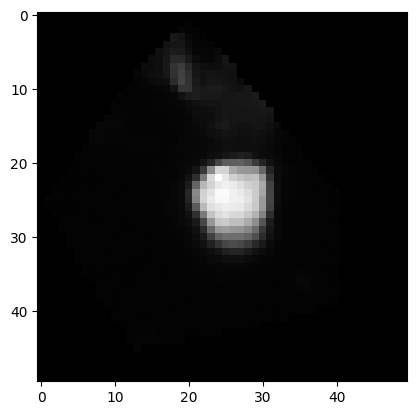

In [31]:
# display_images_in_grid(masked_cells[1])
cluster = 1
index = 3
plt.clf()
plt.close()
plt.imshow(
    masked_cells[cluster][list(unmasked_cells[cluster].keys())[index]], cmap="gray"
)
plt.show()

## Deep Learning

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

### Make the dataset

In [33]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, images_dict, transform=None):
        self.images_dict = images_dict
        self.labels = []
        self.images = []
        for cluster, images in images_dict.items():
            self.images.extend(images.values())
            self.labels.extend([cluster - 1] * len(images))
        self.transform = transform  # Transformation to apply to each image

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert image to PyTorch tensor and normalize if necessary
        image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0
        image_tensor = torch.unsqueeze(image_tensor, 0)
        if self.transform:
            image_tensor = self.transform(image_tensor)  # Apply transformation
        # Convert label to PyTorch tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image_tensor, label_tensor

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    adjusted_rand_score,
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)


def evaluate_model_clusters(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    predictions, true_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted_labels = outputs.argmax(1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Metrics calculation
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    ari = adjusted_rand_score(true_labels, predictions)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average=None, zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = (
        precision_recall_fscore_support(
            true_labels, predictions, average="weighted", zero_division=0
        )
    )

    # Confusion Matrix
    conf_mat = confusion_matrix(true_labels, predictions)

    return {
        "Accuracy": accuracy,
        "Precision": precision_weighted,
        "Recall": recall_weighted,
        "F1 Score": f1_weighted,
        "Adjusted Rand Index": ari,
        "Precision by cluster": precision,
        "Recall by cluster": recall,
        "F1 score by cluster": f1,
        "confusion_matrix": conf_mat,
    }

In [5]:
import torch


def calculate_mean_std(images):
    # Initialize variables to accumulate the sum and sum of squares
    n_images = len(images)
    mean = torch.zeros(1)
    squared_sum = torch.zeros(1)

    for image in images:
        image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0
        mean += torch.mean(image_tensor)
        squared_sum += torch.mean(image_tensor**2)

    # Calculate mean and standard deviation
    mean /= n_images
    std = torch.sqrt(squared_sum / n_images - mean**2)

    return mean.item(), std.item()


mean, std = calculate_mean_std(unmasked_cells)

NameError: name 'unmasked_cells' is not defined

#### Load data and create dataloaders

In [4]:
from torchvision.transforms import AutoAugmentPolicy
from torchvision import transforms

train_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.RandomRotation(50),
        transforms.RandomResizedCrop(50, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(
            [
                mean,
            ],
            [
                std,
            ],
        ),  # Normalize the image
    ]
)
custom_dataset = CustomDataset(unmasked_cells, train_transforms)

train_size = int(0.8 * len(custom_dataset))  # 80% for cross-validation

test_size = len(custom_dataset) - train_size  # Remaining for testing

# Split the dataset into training, validation, and testing sets
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

NameError: name 'mean' is not defined

### Make the models

#### Random simple model

In [37]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.fc1 = nn.Linear(
            64 * 6 * 6, 128
        )  # Adjust input size based on your image size
        self.fc2 = nn.Linear(128, num_classes)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(-1, 64 * 6 * 6)  # Adjust input size based on your image size
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Lab 4b Model

In [38]:
class LabModel(nn.Module):
    def __init__(self):
        super(LabModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1
        )
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(
            64 * 12 * 12, 128
        )  # Adjust input size based on your image size
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 28)  # Assuming 2 classes for binary classification

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 64 * 12 * 12)  # Adjust input size based on your image size
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

    def __name__(self):
        return str(self)

#### AlexNet

In [39]:
import json
import numpy as np


def save_evaluation_results(evaluation_metrics, filepath):
    # Convert all numpy arrays to lists
    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert ndarray to list

    if os.path.exists(filepath):
        os.mkdir(filepath)

    with open(filepath, "w") as f:
        # Use the default function to handle non-serializable data
        json.dump(
            evaluation_metrics,
            f,
            default=convert,
            ensure_ascii=False,
            separators=(",", ":"),
        )

In [40]:
# Define the ResNet model
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F


class ModifiedResNet50(models.ResNet):
    def __init__(self, weights=None, num_classes=28, *args, **kwargs):
        super(ModifiedResNet50, self).__init__(
            block=models.resnet.Bottleneck, layers=[3, 4, 6, 3], *args, **kwargs
        )

        # Initialize a new fully connected layer with the correct number of classes
        self.fc = nn.Linear(2048, num_classes)

        # If weights is provided, load the state_dict with strict=False to avoid errors
        if weights is not None:
            state_dict = weights.state_dict()

            # Remove the weights related to the fully connected layer to avoid mismatch
            if "fc.weight" in state_dict and "fc.bias" in state_dict:
                del state_dict["fc.weight"]
                del state_dict["fc.bias"]

            self.load_state_dict(state_dict, strict=False)

        # Modify the first convolutional layer to accept 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Update the first layer's weights, if weights were provided
        if weights is not None:
            with torch.no_grad():
                original_first_layer = state_dict["conv1.weight"]
                self.conv1.weight.data = original_first_layer.mean(dim=1, keepdim=True)

        # Adding Dropout
        self.dropout = nn.Dropout(0.5)

        # Adding Batch Normalization
        self.bn1 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [41]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F


class ModifiedResNet18(models.ResNet):
    def __init__(self, weights=None, num_classes=28, *args, **kwargs):
        super(ModifiedResNet18, self).__init__(
            block=models.resnet.BasicBlock, layers=[2, 2, 2, 2], *args, **kwargs
        )

        # Initialize a new fully connected layer with the correct number of classes
        self.fc = nn.Linear(512, num_classes)

        # If weights is provided, load the state_dict with strict=False to avoid errors
        if weights is not None:
            state_dict = weights.state_dict()

            # Remove the weights related to the fully connected layer to avoid mismatch
            if "fc.weight" in state_dict and "fc.bias" in state_dict:
                del state_dict["fc.weight"]
                del state_dict["fc.bias"]

            self.load_state_dict(state_dict, strict=False)

        # Modify the first convolutional layer to accept 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Update the first layer's weights, if weights were provided
        if weights is not None:
            with torch.no_grad():
                original_first_layer = state_dict["conv1.weight"]
                self.conv1.weight.data = original_first_layer.mean(dim=1, keepdim=True)

        # Adding Dropout
        self.dropout = nn.Dropout(0.5)

        # Adding Batch Normalization
        self.bn1 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [42]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define a modified Vision Transformer (ViT) with a dropout layer
class ModifiedViT(nn.Module):
    def __init__(
        self,
        model_name="vit_base_patch16_224",
        pretrained=True,
        num_classes=1000,
        dropout_rate=0.3,  # Default dropout rate
    ):
        super(ModifiedViT, self).__init__()

        # Load the pretrained ViT model
        self.vit = timm.create_model(
            model_name, pretrained=pretrained, num_classes=num_classes
        )

        # Modify the patch embedding to handle grayscale images
        original_patch_embedding = self.vit.patch_embed.proj
        self.vit.patch_embed.proj = nn.Conv2d(
            1,
            original_patch_embedding.out_channels,
            kernel_size=original_patch_embedding.kernel_size,
            stride=original_patch_embedding.stride,
            padding=original_patch_embedding.padding,
            bias=False,
        )

        # If using pretrained weights, adjust for grayscale
        if pretrained:
            with torch.no_grad():
                original_weight = original_patch_embedding.weight.mean(
                    dim=1, keepdim=True
                )
                self.vit.patch_embed.proj.weight.data = original_weight

        # Add dropout layer after patch embedding
        self.dropout = nn.Dropout(p=dropout_rate)

        # Replace the classifier head
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        x = self.vit.patch_embed(x)

        cls_token = self.vit.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Apply positional dropout and add positional embedding
        x = self.vit.pos_drop(x + self.vit.pos_embed)

        # Apply dropout before entering transformer blocks
        x = self.dropout(x)

        # Forward through the transformer blocks
        x = self.vit.blocks(x)

        # Apply normalization
        x = self.vit.norm(x)

        # Select CLS token and apply final dropout
        x = self.dropout(x[:, 0])

        # Final classifier head
        x = self.vit.head(x)

        return x

### Train

In [ ]:
import json
import numpy as np
import os


def save_evaluation_results(evaluation_metrics, filepath):
    # Define a helper function to convert numpy arrays to lists for JSON serialization
    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert ndarray to list

    # Ensure the directory exists
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the metrics to the specified JSON file
    with open(filepath, "w") as f:
        # Use the default function to handle non-serializable data
        json.dump(
            evaluation_metrics,
            f,
            default=convert,
            ensure_ascii=False,
            separators=(",", ":"),
        )

In [43]:
import os
import torch
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import RepeatedKFold


def perform_training_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    pbar = tqdm(train_loader, desc="Training", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        total_loss += loss.item() * inputs.size(0)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        pbar.set_postfix(
            loss=f"{total_loss / total_samples:.4f}",
            acc=f"{total_correct / total_samples:.4f}",
        )

    return total_loss / total_samples, total_correct / total_samples


def perform_validation_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0

    pbar = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            pbar.set_postfix(
                loss=f"{total_loss / total_samples:.4f}",
                acc=f"{total_correct / total_samples:.4f}",
            )

    return total_loss / total_samples, total_correct / total_samples


def train_and_evaluate_model(
    ModelClass,
    dataset,
    num_splits=5,
    num_repeats=3,
    num_epochs=20,
    batch_size=32,
    learning_rate=0.0001,
    save_path=None,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    rkfold = RepeatedKFold(n_splits=num_splits, n_repeats=num_repeats, random_state=42)

    all_fold_results = []
    total_iterations = num_splits * num_repeats
    current_iteration = 0

    for train_idx, val_idx in rkfold.split(dataset):
        model = ModelClass().to(
            device
        )  # Initialize a new instance of the model for each fold
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        repeat_number = current_iteration // num_splits + 1
        fold_number = current_iteration % num_splits + 1
        print(f"Starting Repeat {repeat_number}, Fold {fold_number}")

        train_loader = DataLoader(
            Subset(dataset, train_idx),
            batch_size=batch_size,
            shuffle=True,
            num_workers=8,
        )
        val_loader = DataLoader(
            Subset(dataset, val_idx),
            batch_size=batch_size,
            shuffle=False,
            num_workers=8,
        )
        epoch_accuracies = [[], []]

        for epoch in range(num_epochs):
            print(
                f"Epoch {epoch + 1}/{num_epochs}, Repeat {repeat_number}, Fold {fold_number}"
            )
            train_loss, train_accuracy = perform_training_epoch(
                model, train_loader, optimizer, criterion, device
            )
            val_loss, val_accuracy = perform_validation_epoch(
                model, val_loader, criterion, device
            )
            epoch_accuracies[0].append(train_accuracy)
            epoch_accuracies[1].append(val_accuracy)
            print(
                f"Repeat {repeat_number}, Fold {fold_number}, Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Acc = {train_accuracy:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_accuracy:.4f}"
            )

            if epoch == num_epochs - 1:
                evaluation_metrics = evaluate_model_clusters(model, val_loader)
                evaluation_metrics["epoch_accuracies"] = epoch_accuracies
                all_fold_results.append(evaluation_metrics)

                if save_path:
                    if not os.path.exists(save_path):
                        os.makedirs(save_path)

                    model_folder = os.path.join(
                        save_path, f"Repeat_{repeat_number}_Fold_{fold_number}"
                    )
                    if not os.path.exists(model_folder):
                        os.mkdir(model_folder)
                    filepath = os.path.join(model_folder, "evaluation_metrics.json")
                    save_evaluation_results(evaluation_metrics, filepath)
                    torch.save(
                        model.state_dict(), os.path.join(model_folder, "model.pth")
                    )

        current_iteration += 1

    return all_fold_results

In [ ]:
model = LabModel
num_epochs = 50
num_splits = 4
num_repeats = 1
lr_rate = 0.0001
batch_size = 64
save_path = os.path.join(script_dir, "LabModel")


if not os.path.exists(save_path):
    os.makedirs(save_path)

results = train_and_evaluate_model(
    model,
    train_dataset,
    save_path=save_path,
    num_epochs=num_epochs,
    num_splits=num_splits,
    num_repeats=num_repeats,
    batch_size=batch_size,
    learning_rate=lr_rate,
)

Starting Repeat 1, Fold 1
Epoch 1/50, Repeat 1, Fold 1


Training:   0%|          | 0/343 [00:00<?, ?it/s]

Repeat 1, Fold 1, Epoch 1: Train Loss = 3.2298, Train Acc = 0.0788, Val Loss = 3.1289, Val Acc = 0.1126
Epoch 2/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 2: Train Loss = 3.1565, Train Acc = 0.0963, Val Loss = 3.0677, Val Acc = 0.1135
Epoch 3/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 3: Train Loss = 3.1203, Train Acc = 0.1065, Val Loss = 3.0540, Val Acc = 0.1250
Epoch 4/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 4: Train Loss = 3.1006, Train Acc = 0.1120, Val Loss = 3.0540, Val Acc = 0.1325
Epoch 5/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 5: Train Loss = 3.0911, Train Acc = 0.1179, Val Loss = 3.0406, Val Acc = 0.1386
Epoch 6/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 6: Train Loss = 3.0826, Train Acc = 0.1167, Val Loss = 3.0261, Val Acc = 0.1317
Epoch 7/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 7: Train Loss = 3.0708, Train Acc = 0.1220, Val Loss = 3.0193, Val Acc = 0.1403
Epoch 8/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 8: Train Loss = 3.0662, Train Acc = 0.1192, Val Loss = 3.0174, Val Acc = 0.1451
Epoch 9/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 9: Train Loss = 3.0617, Train Acc = 0.1231, Val Loss = 3.0154, Val Acc = 0.1439
Epoch 10/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 10: Train Loss = 3.0542, Train Acc = 0.1258, Val Loss = 3.0039, Val Acc = 0.1439
Epoch 11/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 11: Train Loss = 3.0501, Train Acc = 0.1332, Val Loss = 3.0098, Val Acc = 0.1447
Epoch 12/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 12: Train Loss = 3.0461, Train Acc = 0.1289, Val Loss = 3.0033, Val Acc = 0.1479
Epoch 13/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 13: Train Loss = 3.0467, Train Acc = 0.1307, Val Loss = 3.0006, Val Acc = 0.1503
Epoch 14/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 14: Train Loss = 3.0369, Train Acc = 0.1313, Val Loss = 2.9983, Val Acc = 0.1510
Epoch 15/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 15: Train Loss = 3.0380, Train Acc = 0.1354, Val Loss = 2.9955, Val Acc = 0.1490
Epoch 16/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 16: Train Loss = 3.0279, Train Acc = 0.1363, Val Loss = 2.9898, Val Acc = 0.1522
Epoch 17/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 17: Train Loss = 3.0283, Train Acc = 0.1352, Val Loss = 2.9867, Val Acc = 0.1533
Epoch 18/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 18: Train Loss = 3.0235, Train Acc = 0.1374, Val Loss = 2.9833, Val Acc = 0.1540
Epoch 19/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 19: Train Loss = 3.0179, Train Acc = 0.1381, Val Loss = 2.9756, Val Acc = 0.1551
Epoch 20/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 20: Train Loss = 3.0143, Train Acc = 0.1386, Val Loss = 2.9721, Val Acc = 0.1572
Epoch 21/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 21: Train Loss = 3.0137, Train Acc = 0.1403, Val Loss = 2.9766, Val Acc = 0.1522
Epoch 22/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 22: Train Loss = 3.0072, Train Acc = 0.1427, Val Loss = 2.9682, Val Acc = 0.1588
Epoch 23/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 23: Train Loss = 3.0055, Train Acc = 0.1444, Val Loss = 2.9586, Val Acc = 0.1581
Epoch 24/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 24: Train Loss = 2.9975, Train Acc = 0.1448, Val Loss = 2.9608, Val Acc = 0.1584
Epoch 25/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 25: Train Loss = 2.9991, Train Acc = 0.1454, Val Loss = 2.9579, Val Acc = 0.1569
Epoch 26/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 26: Train Loss = 2.9937, Train Acc = 0.1461, Val Loss = 2.9565, Val Acc = 0.1609
Epoch 27/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 27: Train Loss = 2.9933, Train Acc = 0.1459, Val Loss = 2.9514, Val Acc = 0.1632
Epoch 28/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 28: Train Loss = 2.9894, Train Acc = 0.1444, Val Loss = 2.9524, Val Acc = 0.1593
Epoch 29/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 29: Train Loss = 2.9844, Train Acc = 0.1472, Val Loss = 2.9493, Val Acc = 0.1581
Epoch 30/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 30: Train Loss = 2.9820, Train Acc = 0.1500, Val Loss = 2.9450, Val Acc = 0.1667
Epoch 31/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 31: Train Loss = 2.9814, Train Acc = 0.1485, Val Loss = 2.9488, Val Acc = 0.1602
Epoch 32/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 32: Train Loss = 2.9827, Train Acc = 0.1514, Val Loss = 2.9381, Val Acc = 0.1632
Epoch 33/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 33: Train Loss = 2.9729, Train Acc = 0.1494, Val Loss = 2.9426, Val Acc = 0.1635
Epoch 34/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 34: Train Loss = 2.9754, Train Acc = 0.1500, Val Loss = 2.9370, Val Acc = 0.1648
Epoch 35/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 35: Train Loss = 2.9714, Train Acc = 0.1504, Val Loss = 2.9287, Val Acc = 0.1647
Epoch 36/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 36: Train Loss = 2.9699, Train Acc = 0.1503, Val Loss = 2.9278, Val Acc = 0.1643
Epoch 37/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 37: Train Loss = 2.9699, Train Acc = 0.1528, Val Loss = 2.9243, Val Acc = 0.1651
Epoch 38/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 38: Train Loss = 2.9684, Train Acc = 0.1517, Val Loss = 2.9299, Val Acc = 0.1659
Epoch 39/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 39: Train Loss = 2.9647, Train Acc = 0.1510, Val Loss = 2.9226, Val Acc = 0.1656
Epoch 40/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 40: Train Loss = 2.9646, Train Acc = 0.1526, Val Loss = 2.9252, Val Acc = 0.1671
Epoch 41/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 41: Train Loss = 2.9624, Train Acc = 0.1497, Val Loss = 2.9249, Val Acc = 0.1662
Epoch 42/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 42: Train Loss = 2.9587, Train Acc = 0.1519, Val Loss = 2.9266, Val Acc = 0.1645
Epoch 43/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 43: Train Loss = 2.9569, Train Acc = 0.1533, Val Loss = 2.9234, Val Acc = 0.1654
Epoch 44/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 44: Train Loss = 2.9589, Train Acc = 0.1544, Val Loss = 2.9234, Val Acc = 0.1656
Epoch 45/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 45: Train Loss = 2.9573, Train Acc = 0.1545, Val Loss = 2.9239, Val Acc = 0.1659
Epoch 46/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 46: Train Loss = 2.9587, Train Acc = 0.1511, Val Loss = 2.9267, Val Acc = 0.1643
Epoch 47/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 47: Train Loss = 2.9548, Train Acc = 0.1555, Val Loss = 2.9159, Val Acc = 0.1654
Epoch 48/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 48: Train Loss = 2.9502, Train Acc = 0.1528, Val Loss = 2.9204, Val Acc = 0.1655
Epoch 49/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 49: Train Loss = 2.9531, Train Acc = 0.1559, Val Loss = 2.9124, Val Acc = 0.1656
Epoch 50/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 50: Train Loss = 2.9531, Train Acc = 0.1544, Val Loss = 2.9117, Val Acc = 0.1680


Starting Repeat 1, Fold 2
Epoch 1/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 1: Train Loss = 3.2334, Train Acc = 0.0798, Val Loss = 3.1087, Val Acc = 0.1219
Epoch 2/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 2: Train Loss = 3.1527, Train Acc = 0.1020, Val Loss = 3.0688, Val Acc = 0.1269
Epoch 3/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 3: Train Loss = 3.1180, Train Acc = 0.1113, Val Loss = 3.0719, Val Acc = 0.1289
Epoch 4/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 4: Train Loss = 3.1006, Train Acc = 0.1111, Val Loss = 3.0489, Val Acc = 0.1313
Epoch 5/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 5: Train Loss = 3.0916, Train Acc = 0.1144, Val Loss = 3.0408, Val Acc = 0.1323
Epoch 6/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 6: Train Loss = 3.0748, Train Acc = 0.1193, Val Loss = 3.0413, Val Acc = 0.1386
Epoch 7/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 7: Train Loss = 3.0716, Train Acc = 0.1250, Val Loss = 3.0234, Val Acc = 0.1415
Epoch 8/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 8: Train Loss = 3.0642, Train Acc = 0.1223, Val Loss = 3.0349, Val Acc = 0.1368
Epoch 9/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 9: Train Loss = 3.0550, Train Acc = 0.1229, Val Loss = 3.0162, Val Acc = 0.1397
Epoch 10/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 10: Train Loss = 3.0497, Train Acc = 0.1281, Val Loss = 3.0122, Val Acc = 0.1405
Epoch 11/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 11: Train Loss = 3.0455, Train Acc = 0.1304, Val Loss = 3.0079, Val Acc = 0.1423
Epoch 12/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 12: Train Loss = 3.0411, Train Acc = 0.1308, Val Loss = 3.0024, Val Acc = 0.1454
Epoch 13/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 13: Train Loss = 3.0328, Train Acc = 0.1348, Val Loss = 3.0006, Val Acc = 0.1431
Epoch 14/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 14: Train Loss = 3.0345, Train Acc = 0.1347, Val Loss = 2.9977, Val Acc = 0.1451
Epoch 15/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 15: Train Loss = 3.0297, Train Acc = 0.1365, Val Loss = 2.9898, Val Acc = 0.1453
Epoch 16/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 16: Train Loss = 3.0198, Train Acc = 0.1393, Val Loss = 2.9903, Val Acc = 0.1461
Epoch 17/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 17: Train Loss = 3.0195, Train Acc = 0.1393, Val Loss = 2.9834, Val Acc = 0.1484
Epoch 18/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 18: Train Loss = 3.0202, Train Acc = 0.1404, Val Loss = 2.9814, Val Acc = 0.1497
Epoch 19/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 19: Train Loss = 3.0102, Train Acc = 0.1420, Val Loss = 2.9837, Val Acc = 0.1468
Epoch 20/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 20: Train Loss = 3.0105, Train Acc = 0.1414, Val Loss = 2.9758, Val Acc = 0.1518
Epoch 21/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 21: Train Loss = 3.0056, Train Acc = 0.1440, Val Loss = 2.9736, Val Acc = 0.1518
Epoch 22/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 22: Train Loss = 3.0043, Train Acc = 0.1450, Val Loss = 2.9812, Val Acc = 0.1438
Epoch 23/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 23: Train Loss = 3.0001, Train Acc = 0.1450, Val Loss = 2.9730, Val Acc = 0.1529
Epoch 24/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 24: Train Loss = 2.9969, Train Acc = 0.1480, Val Loss = 2.9573, Val Acc = 0.1505
Epoch 25/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 25: Train Loss = 2.9908, Train Acc = 0.1492, Val Loss = 2.9605, Val Acc = 0.1539
Epoch 26/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 26: Train Loss = 2.9902, Train Acc = 0.1452, Val Loss = 2.9585, Val Acc = 0.1540
Epoch 27/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 27: Train Loss = 2.9871, Train Acc = 0.1515, Val Loss = 2.9602, Val Acc = 0.1551
Epoch 28/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 28: Train Loss = 2.9843, Train Acc = 0.1498, Val Loss = 2.9457, Val Acc = 0.1569
Epoch 29/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 29: Train Loss = 2.9802, Train Acc = 0.1483, Val Loss = 2.9418, Val Acc = 0.1555
Epoch 30/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 30: Train Loss = 2.9805, Train Acc = 0.1512, Val Loss = 2.9458, Val Acc = 0.1580
Epoch 31/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 31: Train Loss = 2.9739, Train Acc = 0.1513, Val Loss = 2.9462, Val Acc = 0.1570
Epoch 32/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 32: Train Loss = 2.9736, Train Acc = 0.1542, Val Loss = 2.9406, Val Acc = 0.1613
Epoch 33/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 33: Train Loss = 2.9747, Train Acc = 0.1506, Val Loss = 2.9426, Val Acc = 0.1588
Epoch 34/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 34: Train Loss = 2.9733, Train Acc = 0.1524, Val Loss = 2.9403, Val Acc = 0.1580
Epoch 35/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 35: Train Loss = 2.9654, Train Acc = 0.1535, Val Loss = 2.9376, Val Acc = 0.1590
Epoch 36/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 36: Train Loss = 2.9647, Train Acc = 0.1547, Val Loss = 2.9381, Val Acc = 0.1617
Epoch 37/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 37: Train Loss = 2.9651, Train Acc = 0.1538, Val Loss = 2.9335, Val Acc = 0.1581
Epoch 38/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 38: Train Loss = 2.9628, Train Acc = 0.1565, Val Loss = 2.9328, Val Acc = 0.1602
Epoch 39/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 39: Train Loss = 2.9611, Train Acc = 0.1544, Val Loss = 2.9275, Val Acc = 0.1584
Epoch 40/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 40: Train Loss = 2.9612, Train Acc = 0.1558, Val Loss = 2.9249, Val Acc = 0.1596
Epoch 41/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 41: Train Loss = 2.9580, Train Acc = 0.1566, Val Loss = 2.9269, Val Acc = 0.1588
Epoch 42/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 42: Train Loss = 2.9582, Train Acc = 0.1563, Val Loss = 2.9251, Val Acc = 0.1618
Epoch 43/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 43: Train Loss = 2.9581, Train Acc = 0.1561, Val Loss = 2.9303, Val Acc = 0.1603
Epoch 44/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 44: Train Loss = 2.9575, Train Acc = 0.1561, Val Loss = 2.9238, Val Acc = 0.1595
Epoch 45/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 45: Train Loss = 2.9513, Train Acc = 0.1583, Val Loss = 2.9315, Val Acc = 0.1603
Epoch 46/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 46: Train Loss = 2.9547, Train Acc = 0.1561, Val Loss = 2.9241, Val Acc = 0.1572
Epoch 47/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 47: Train Loss = 2.9527, Train Acc = 0.1581, Val Loss = 2.9230, Val Acc = 0.1633
Epoch 48/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 48: Train Loss = 2.9481, Train Acc = 0.1582, Val Loss = 2.9194, Val Acc = 0.1613
Epoch 49/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 49: Train Loss = 2.9473, Train Acc = 0.1571, Val Loss = 2.9152, Val Acc = 0.1620
Epoch 50/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 50: Train Loss = 2.9488, Train Acc = 0.1581, Val Loss = 2.9179, Val Acc = 0.1590


Starting Repeat 1, Fold 3
Epoch 1/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 1: Train Loss = 3.2320, Train Acc = 0.0812, Val Loss = 3.1278, Val Acc = 0.1119
Epoch 2/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 2: Train Loss = 3.1540, Train Acc = 0.1022, Val Loss = 3.0792, Val Acc = 0.1235
Epoch 3/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 3: Train Loss = 3.1250, Train Acc = 0.1079, Val Loss = 3.0708, Val Acc = 0.1293
Epoch 4/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 4: Train Loss = 3.1124, Train Acc = 0.1113, Val Loss = 3.0619, Val Acc = 0.1330
Epoch 5/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 5: Train Loss = 3.0942, Train Acc = 0.1149, Val Loss = 3.0369, Val Acc = 0.1320
Epoch 6/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 6: Train Loss = 3.0833, Train Acc = 0.1171, Val Loss = 3.0413, Val Acc = 0.1289
Epoch 7/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 7: Train Loss = 3.0752, Train Acc = 0.1226, Val Loss = 3.0313, Val Acc = 0.1316
Epoch 8/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 8: Train Loss = 3.0713, Train Acc = 0.1219, Val Loss = 3.0294, Val Acc = 0.1342
Epoch 9/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 9: Train Loss = 3.0627, Train Acc = 0.1260, Val Loss = 3.0199, Val Acc = 0.1394
Epoch 10/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 10: Train Loss = 3.0569, Train Acc = 0.1264, Val Loss = 3.0198, Val Acc = 0.1376
Epoch 11/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 11: Train Loss = 3.0547, Train Acc = 0.1268, Val Loss = 3.0165, Val Acc = 0.1375
Epoch 12/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 12: Train Loss = 3.0539, Train Acc = 0.1288, Val Loss = 3.0214, Val Acc = 0.1391
Epoch 13/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 13: Train Loss = 3.0469, Train Acc = 0.1339, Val Loss = 3.0181, Val Acc = 0.1383
Epoch 14/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 14: Train Loss = 3.0439, Train Acc = 0.1380, Val Loss = 3.0029, Val Acc = 0.1373
Epoch 15/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 15: Train Loss = 3.0389, Train Acc = 0.1363, Val Loss = 2.9943, Val Acc = 0.1430
Epoch 16/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 16: Train Loss = 3.0355, Train Acc = 0.1379, Val Loss = 3.0039, Val Acc = 0.1431
Epoch 17/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 17: Train Loss = 3.0304, Train Acc = 0.1391, Val Loss = 2.9993, Val Acc = 0.1425
Epoch 18/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 18: Train Loss = 3.0288, Train Acc = 0.1364, Val Loss = 2.9916, Val Acc = 0.1431
Epoch 19/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 19: Train Loss = 3.0271, Train Acc = 0.1415, Val Loss = 2.9880, Val Acc = 0.1421
Epoch 20/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 20: Train Loss = 3.0237, Train Acc = 0.1390, Val Loss = 2.9823, Val Acc = 0.1436
Epoch 21/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 21: Train Loss = 3.0215, Train Acc = 0.1414, Val Loss = 2.9812, Val Acc = 0.1451
Epoch 22/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 22: Train Loss = 3.0107, Train Acc = 0.1410, Val Loss = 2.9801, Val Acc = 0.1442
Epoch 23/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 23: Train Loss = 3.0124, Train Acc = 0.1463, Val Loss = 2.9793, Val Acc = 0.1486
Epoch 24/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 24: Train Loss = 3.0088, Train Acc = 0.1443, Val Loss = 2.9717, Val Acc = 0.1458
Epoch 25/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 25: Train Loss = 3.0030, Train Acc = 0.1441, Val Loss = 2.9837, Val Acc = 0.1479
Epoch 26/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 26: Train Loss = 3.0001, Train Acc = 0.1484, Val Loss = 2.9741, Val Acc = 0.1492
Epoch 27/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 27: Train Loss = 2.9996, Train Acc = 0.1464, Val Loss = 2.9766, Val Acc = 0.1486
Epoch 28/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 28: Train Loss = 2.9964, Train Acc = 0.1473, Val Loss = 2.9678, Val Acc = 0.1471
Epoch 29/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 29: Train Loss = 2.9960, Train Acc = 0.1497, Val Loss = 2.9604, Val Acc = 0.1487
Epoch 30/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 30: Train Loss = 2.9879, Train Acc = 0.1487, Val Loss = 2.9598, Val Acc = 0.1469
Epoch 31/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 31: Train Loss = 2.9920, Train Acc = 0.1483, Val Loss = 2.9572, Val Acc = 0.1502
Epoch 32/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 32: Train Loss = 2.9851, Train Acc = 0.1497, Val Loss = 2.9563, Val Acc = 0.1509
Epoch 33/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 33: Train Loss = 2.9799, Train Acc = 0.1499, Val Loss = 2.9499, Val Acc = 0.1502
Epoch 34/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 34: Train Loss = 2.9809, Train Acc = 0.1516, Val Loss = 2.9523, Val Acc = 0.1512
Epoch 35/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 35: Train Loss = 2.9787, Train Acc = 0.1523, Val Loss = 2.9473, Val Acc = 0.1535
Epoch 36/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 36: Train Loss = 2.9779, Train Acc = 0.1517, Val Loss = 2.9475, Val Acc = 0.1497
Epoch 37/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 37: Train Loss = 2.9756, Train Acc = 0.1541, Val Loss = 2.9487, Val Acc = 0.1502
Epoch 38/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 38: Train Loss = 2.9767, Train Acc = 0.1517, Val Loss = 2.9365, Val Acc = 0.1517
Epoch 39/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 39: Train Loss = 2.9767, Train Acc = 0.1538, Val Loss = 2.9402, Val Acc = 0.1520
Epoch 40/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 40: Train Loss = 2.9702, Train Acc = 0.1533, Val Loss = 2.9322, Val Acc = 0.1543
Epoch 41/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 41: Train Loss = 2.9713, Train Acc = 0.1533, Val Loss = 2.9407, Val Acc = 0.1525
Epoch 42/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 42: Train Loss = 2.9668, Train Acc = 0.1547, Val Loss = 2.9337, Val Acc = 0.1538
Epoch 43/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 43: Train Loss = 2.9652, Train Acc = 0.1547, Val Loss = 2.9337, Val Acc = 0.1547
Epoch 44/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 44: Train Loss = 2.9646, Train Acc = 0.1543, Val Loss = 2.9311, Val Acc = 0.1538
Epoch 45/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 45: Train Loss = 2.9613, Train Acc = 0.1563, Val Loss = 2.9329, Val Acc = 0.1570
Epoch 46/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 46: Train Loss = 2.9609, Train Acc = 0.1571, Val Loss = 2.9346, Val Acc = 0.1551
Epoch 47/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 47: Train Loss = 2.9622, Train Acc = 0.1558, Val Loss = 2.9293, Val Acc = 0.1555
Epoch 48/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 48: Train Loss = 2.9547, Train Acc = 0.1567, Val Loss = 2.9273, Val Acc = 0.1503
Epoch 49/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 49: Train Loss = 2.9587, Train Acc = 0.1574, Val Loss = 2.9271, Val Acc = 0.1558
Epoch 50/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 50: Train Loss = 2.9511, Train Acc = 0.1592, Val Loss = 2.9227, Val Acc = 0.1543


Starting Repeat 1, Fold 4
Epoch 1/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 1: Train Loss = 3.2280, Train Acc = 0.0780, Val Loss = 3.1268, Val Acc = 0.1150
Epoch 2/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 2: Train Loss = 3.1425, Train Acc = 0.1035, Val Loss = 3.0606, Val Acc = 0.1178
Epoch 3/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 3: Train Loss = 3.1144, Train Acc = 0.1088, Val Loss = 3.0382, Val Acc = 0.1231
Epoch 4/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 4: Train Loss = 3.0972, Train Acc = 0.1107, Val Loss = 3.0285, Val Acc = 0.1309
Epoch 5/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 5: Train Loss = 3.0852, Train Acc = 0.1132, Val Loss = 3.0220, Val Acc = 0.1363
Epoch 6/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 6: Train Loss = 3.0782, Train Acc = 0.1168, Val Loss = 3.0259, Val Acc = 0.1353
Epoch 7/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 7: Train Loss = 3.0698, Train Acc = 0.1239, Val Loss = 3.0152, Val Acc = 0.1394
Epoch 8/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 8: Train Loss = 3.0674, Train Acc = 0.1212, Val Loss = 3.0196, Val Acc = 0.1434
Epoch 9/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 9: Train Loss = 3.0623, Train Acc = 0.1246, Val Loss = 3.0035, Val Acc = 0.1399
Epoch 10/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 10: Train Loss = 3.0564, Train Acc = 0.1265, Val Loss = 3.0090, Val Acc = 0.1380
Epoch 11/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 11: Train Loss = 3.0510, Train Acc = 0.1300, Val Loss = 3.0097, Val Acc = 0.1376
Epoch 12/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 12: Train Loss = 3.0473, Train Acc = 0.1320, Val Loss = 3.0124, Val Acc = 0.1413
Epoch 13/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 13: Train Loss = 3.0456, Train Acc = 0.1331, Val Loss = 2.9988, Val Acc = 0.1456
Epoch 14/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 14: Train Loss = 3.0401, Train Acc = 0.1364, Val Loss = 2.9917, Val Acc = 0.1469
Epoch 15/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 15: Train Loss = 3.0380, Train Acc = 0.1359, Val Loss = 2.9946, Val Acc = 0.1454
Epoch 16/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 16: Train Loss = 3.0320, Train Acc = 0.1366, Val Loss = 2.9926, Val Acc = 0.1472
Epoch 17/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 17: Train Loss = 3.0312, Train Acc = 0.1383, Val Loss = 2.9914, Val Acc = 0.1482
Epoch 18/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 18: Train Loss = 3.0278, Train Acc = 0.1381, Val Loss = 2.9894, Val Acc = 0.1487
Epoch 19/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 19: Train Loss = 3.0227, Train Acc = 0.1415, Val Loss = 2.9787, Val Acc = 0.1473
Epoch 20/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 20: Train Loss = 3.0178, Train Acc = 0.1427, Val Loss = 2.9774, Val Acc = 0.1471
Epoch 21/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 21: Train Loss = 3.0158, Train Acc = 0.1400, Val Loss = 2.9693, Val Acc = 0.1520
Epoch 22/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 22: Train Loss = 3.0133, Train Acc = 0.1415, Val Loss = 2.9775, Val Acc = 0.1487
Epoch 23/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 23: Train Loss = 3.0095, Train Acc = 0.1461, Val Loss = 2.9685, Val Acc = 0.1531
Epoch 24/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 24: Train Loss = 3.0061, Train Acc = 0.1466, Val Loss = 2.9592, Val Acc = 0.1532
Epoch 25/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 25: Train Loss = 2.9978, Train Acc = 0.1474, Val Loss = 2.9596, Val Acc = 0.1521
Epoch 26/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 26: Train Loss = 2.9956, Train Acc = 0.1478, Val Loss = 2.9569, Val Acc = 0.1531
Epoch 27/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 27: Train Loss = 2.9935, Train Acc = 0.1489, Val Loss = 2.9739, Val Acc = 0.1502
Epoch 28/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 28: Train Loss = 2.9956, Train Acc = 0.1472, Val Loss = 2.9604, Val Acc = 0.1518
Epoch 29/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 29: Train Loss = 2.9919, Train Acc = 0.1496, Val Loss = 2.9530, Val Acc = 0.1527
Epoch 30/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 30: Train Loss = 2.9861, Train Acc = 0.1483, Val Loss = 2.9500, Val Acc = 0.1501
Epoch 31/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 31: Train Loss = 2.9808, Train Acc = 0.1497, Val Loss = 2.9496, Val Acc = 0.1579
Epoch 32/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 32: Train Loss = 2.9836, Train Acc = 0.1499, Val Loss = 2.9524, Val Acc = 0.1540
Epoch 33/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 33: Train Loss = 2.9788, Train Acc = 0.1515, Val Loss = 2.9427, Val Acc = 0.1577
Epoch 34/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 34: Train Loss = 2.9745, Train Acc = 0.1510, Val Loss = 2.9397, Val Acc = 0.1551
Epoch 35/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 35: Train Loss = 2.9721, Train Acc = 0.1528, Val Loss = 2.9394, Val Acc = 0.1547
Epoch 36/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 36: Train Loss = 2.9749, Train Acc = 0.1522, Val Loss = 2.9372, Val Acc = 0.1558
Epoch 37/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 37: Train Loss = 2.9757, Train Acc = 0.1516, Val Loss = 2.9320, Val Acc = 0.1587
Epoch 38/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 38: Train Loss = 2.9706, Train Acc = 0.1512, Val Loss = 2.9393, Val Acc = 0.1568
Epoch 39/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 39: Train Loss = 2.9721, Train Acc = 0.1518, Val Loss = 2.9325, Val Acc = 0.1546
Epoch 40/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 40: Train Loss = 2.9682, Train Acc = 0.1541, Val Loss = 2.9298, Val Acc = 0.1592
Epoch 41/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 41: Train Loss = 2.9648, Train Acc = 0.1567, Val Loss = 2.9258, Val Acc = 0.1572
Epoch 42/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 42: Train Loss = 2.9662, Train Acc = 0.1552, Val Loss = 2.9270, Val Acc = 0.1579
Epoch 43/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 43: Train Loss = 2.9619, Train Acc = 0.1549, Val Loss = 2.9247, Val Acc = 0.1555
Epoch 44/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 44: Train Loss = 2.9628, Train Acc = 0.1514, Val Loss = 2.9404, Val Acc = 0.1570
Epoch 45/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 45: Train Loss = 2.9621, Train Acc = 0.1540, Val Loss = 2.9287, Val Acc = 0.1628
Epoch 46/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 46: Train Loss = 2.9574, Train Acc = 0.1554, Val Loss = 2.9218, Val Acc = 0.1576
Epoch 47/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 47: Train Loss = 2.9566, Train Acc = 0.1548, Val Loss = 2.9302, Val Acc = 0.1580
Epoch 48/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 48: Train Loss = 2.9561, Train Acc = 0.1572, Val Loss = 2.9209, Val Acc = 0.1585
Epoch 49/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 49: Train Loss = 2.9560, Train Acc = 0.1562, Val Loss = 2.9222, Val Acc = 0.1585
Epoch 50/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 50: Train Loss = 2.9550, Train Acc = 0.1563, Val Loss = 2.9201, Val Acc = 0.1572


In [ ]:
model = ModifiedResNet18
num_epochs = 50
num_splits = 4
num_repeats = 1
lr_rate = 0.0001
batch_size = 64
save_path = os.path.join(script_dir, "ResNet18")


if not os.path.exists(save_path):
    os.makedirs(save_path)

results = train_and_evaluate_model(
    model,
    train_dataset,
    save_path=save_path,
    num_epochs=num_epochs,
    num_splits=num_splits,
    num_repeats=num_repeats,
    batch_size=batch_size,
    learning_rate=lr_rate,
)

Starting Repeat 1, Fold 1
Epoch 1/50, Repeat 1, Fold 1


Training:   0%|          | 0/343 [00:00<?, ?it/s]

Repeat 1, Fold 1, Epoch 1: Train Loss = 3.0631, Train Acc = 0.1183, Val Loss = 3.2038, Val Acc = 0.1194
Epoch 2/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 2: Train Loss = 3.0128, Train Acc = 0.1316, Val Loss = 3.1118, Val Acc = 0.1299
Epoch 3/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 3: Train Loss = 2.9977, Train Acc = 0.1384, Val Loss = 3.1474, Val Acc = 0.1220
Epoch 4/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 4: Train Loss = 2.9854, Train Acc = 0.1435, Val Loss = 3.0222, Val Acc = 0.1421
Epoch 5/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 5: Train Loss = 2.9795, Train Acc = 0.1415, Val Loss = 3.0566, Val Acc = 0.1258
Epoch 6/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 6: Train Loss = 2.9716, Train Acc = 0.1427, Val Loss = 3.0368, Val Acc = 0.1293
Epoch 7/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 7: Train Loss = 2.9512, Train Acc = 0.1479, Val Loss = 3.1650, Val Acc = 0.1014
Epoch 8/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 8: Train Loss = 2.9344, Train Acc = 0.1566, Val Loss = 3.1276, Val Acc = 0.1018
Epoch 9/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 9: Train Loss = 2.9269, Train Acc = 0.1546, Val Loss = 2.9824, Val Acc = 0.1524
Epoch 10/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 10: Train Loss = 2.9159, Train Acc = 0.1586, Val Loss = 2.9896, Val Acc = 0.1454
Epoch 11/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 11: Train Loss = 2.9091, Train Acc = 0.1597, Val Loss = 2.9708, Val Acc = 0.1470
Epoch 12/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 12: Train Loss = 2.8993, Train Acc = 0.1604, Val Loss = 2.9303, Val Acc = 0.1533
Epoch 13/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 13: Train Loss = 2.8950, Train Acc = 0.1597, Val Loss = 2.9460, Val Acc = 0.1406
Epoch 14/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 14: Train Loss = 2.8891, Train Acc = 0.1627, Val Loss = 2.9576, Val Acc = 0.1413
Epoch 15/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 15: Train Loss = 2.8832, Train Acc = 0.1637, Val Loss = 2.9545, Val Acc = 0.1496
Epoch 16/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 16: Train Loss = 2.8784, Train Acc = 0.1663, Val Loss = 2.9681, Val Acc = 0.1432
Epoch 17/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 17: Train Loss = 2.8708, Train Acc = 0.1694, Val Loss = 2.9523, Val Acc = 0.1414
Epoch 18/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 18: Train Loss = 2.8657, Train Acc = 0.1683, Val Loss = 2.9020, Val Acc = 0.1670
Epoch 19/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 19: Train Loss = 2.8624, Train Acc = 0.1700, Val Loss = 2.9082, Val Acc = 0.1652
Epoch 20/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 20: Train Loss = 2.8535, Train Acc = 0.1677, Val Loss = 2.9400, Val Acc = 0.1492
Epoch 21/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 21: Train Loss = 2.8484, Train Acc = 0.1778, Val Loss = 2.9162, Val Acc = 0.1588
Epoch 22/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 22: Train Loss = 2.8443, Train Acc = 0.1755, Val Loss = 2.8881, Val Acc = 0.1641
Epoch 23/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 23: Train Loss = 2.8425, Train Acc = 0.1748, Val Loss = 2.8866, Val Acc = 0.1613
Epoch 24/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 24: Train Loss = 2.8396, Train Acc = 0.1758, Val Loss = 2.8909, Val Acc = 0.1704
Epoch 25/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 25: Train Loss = 2.8346, Train Acc = 0.1743, Val Loss = 2.9055, Val Acc = 0.1576
Epoch 26/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 26: Train Loss = 2.8317, Train Acc = 0.1790, Val Loss = 2.9360, Val Acc = 0.1520
Epoch 27/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 27: Train Loss = 2.8265, Train Acc = 0.1773, Val Loss = 2.9016, Val Acc = 0.1684
Epoch 28/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 28: Train Loss = 2.8241, Train Acc = 0.1819, Val Loss = 2.8814, Val Acc = 0.1700
Epoch 29/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 29: Train Loss = 2.8231, Train Acc = 0.1818, Val Loss = 2.8794, Val Acc = 0.1652
Epoch 30/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 30: Train Loss = 2.8152, Train Acc = 0.1823, Val Loss = 2.8747, Val Acc = 0.1707
Epoch 31/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 31: Train Loss = 2.8128, Train Acc = 0.1834, Val Loss = 2.8892, Val Acc = 0.1682
Epoch 32/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 32: Train Loss = 2.8114, Train Acc = 0.1824, Val Loss = 2.8575, Val Acc = 0.1763
Epoch 33/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 33: Train Loss = 2.8067, Train Acc = 0.1843, Val Loss = 2.8950, Val Acc = 0.1656
Epoch 34/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 34: Train Loss = 2.8062, Train Acc = 0.1862, Val Loss = 2.8913, Val Acc = 0.1659
Epoch 35/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 35: Train Loss = 2.8013, Train Acc = 0.1856, Val Loss = 2.8992, Val Acc = 0.1626
Epoch 36/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 36: Train Loss = 2.7972, Train Acc = 0.1885, Val Loss = 2.8794, Val Acc = 0.1662
Epoch 37/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 37: Train Loss = 2.7940, Train Acc = 0.1880, Val Loss = 2.8647, Val Acc = 0.1708
Epoch 38/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 38: Train Loss = 2.7900, Train Acc = 0.1907, Val Loss = 2.8772, Val Acc = 0.1732
Epoch 39/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 39: Train Loss = 2.7919, Train Acc = 0.1870, Val Loss = 2.8867, Val Acc = 0.1755
Epoch 40/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 40: Train Loss = 2.7842, Train Acc = 0.1889, Val Loss = 2.8815, Val Acc = 0.1650
Epoch 41/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 41: Train Loss = 2.7818, Train Acc = 0.1923, Val Loss = 2.8995, Val Acc = 0.1621
Epoch 42/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 42: Train Loss = 2.7785, Train Acc = 0.1929, Val Loss = 2.8605, Val Acc = 0.1769
Epoch 43/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 43: Train Loss = 2.7768, Train Acc = 0.1909, Val Loss = 2.8775, Val Acc = 0.1669
Epoch 44/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 44: Train Loss = 2.7713, Train Acc = 0.1916, Val Loss = 2.8795, Val Acc = 0.1737
Epoch 45/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 45: Train Loss = 2.7704, Train Acc = 0.1937, Val Loss = 2.8670, Val Acc = 0.1736
Epoch 46/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 46: Train Loss = 2.7676, Train Acc = 0.1940, Val Loss = 2.8843, Val Acc = 0.1725
Epoch 47/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 47: Train Loss = 2.7611, Train Acc = 0.1970, Val Loss = 2.8729, Val Acc = 0.1697
Epoch 48/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 48: Train Loss = 2.7570, Train Acc = 0.1937, Val Loss = 2.8649, Val Acc = 0.1760
Epoch 49/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 49: Train Loss = 2.7556, Train Acc = 0.1971, Val Loss = 2.8885, Val Acc = 0.1710
Epoch 50/50, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 50: Train Loss = 2.7505, Train Acc = 0.1981, Val Loss = 2.9017, Val Acc = 0.1641
Starting Repeat 1, Fold 2
Epoch 1/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 1: Train Loss = 3.0616, Train Acc = 0.1176, Val Loss = 3.1149, Val Acc = 0.1192
Epoch 2/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 2: Train Loss = 3.0086, Train Acc = 0.1348, Val Loss = 3.0695, Val Acc = 0.1190
Epoch 3/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 3: Train Loss = 2.9932, Train Acc = 0.1395, Val Loss = 3.0565, Val Acc = 0.1187
Epoch 4/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 4: Train Loss = 2.9824, Train Acc = 0.1429, Val Loss = 3.0458, Val Acc = 0.1295
Epoch 5/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 5: Train Loss = 2.9746, Train Acc = 0.1428, Val Loss = 3.0828, Val Acc = 0.1250
Epoch 6/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 6: Train Loss = 2.9599, Train Acc = 0.1481, Val Loss = 3.0745, Val Acc = 0.1269
Epoch 7/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 7: Train Loss = 2.9489, Train Acc = 0.1484, Val Loss = 3.0384, Val Acc = 0.1297
Epoch 8/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 8: Train Loss = 2.9332, Train Acc = 0.1527, Val Loss = 2.9881, Val Acc = 0.1406
Epoch 9/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 9: Train Loss = 2.9205, Train Acc = 0.1574, Val Loss = 2.9734, Val Acc = 0.1432
Epoch 10/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 10: Train Loss = 2.9118, Train Acc = 0.1592, Val Loss = 3.1218, Val Acc = 0.1272
Epoch 11/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 11: Train Loss = 2.9092, Train Acc = 0.1611, Val Loss = 2.9454, Val Acc = 0.1540
Epoch 12/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 12: Train Loss = 2.9009, Train Acc = 0.1622, Val Loss = 2.9314, Val Acc = 0.1525
Epoch 13/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 13: Train Loss = 2.8964, Train Acc = 0.1623, Val Loss = 2.9403, Val Acc = 0.1543
Epoch 14/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 14: Train Loss = 2.8892, Train Acc = 0.1642, Val Loss = 2.9753, Val Acc = 0.1369
Epoch 15/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 15: Train Loss = 2.8849, Train Acc = 0.1681, Val Loss = 2.9520, Val Acc = 0.1487
Epoch 16/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 16: Train Loss = 2.8789, Train Acc = 0.1697, Val Loss = 2.9453, Val Acc = 0.1435
Epoch 17/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 17: Train Loss = 2.8703, Train Acc = 0.1688, Val Loss = 2.9411, Val Acc = 0.1542
Epoch 18/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 18: Train Loss = 2.8644, Train Acc = 0.1716, Val Loss = 2.9322, Val Acc = 0.1472
Epoch 19/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 19: Train Loss = 2.8600, Train Acc = 0.1725, Val Loss = 2.9185, Val Acc = 0.1610
Epoch 20/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 20: Train Loss = 2.8565, Train Acc = 0.1726, Val Loss = 2.8899, Val Acc = 0.1689
Epoch 21/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 21: Train Loss = 2.8500, Train Acc = 0.1723, Val Loss = 2.8904, Val Acc = 0.1663
Epoch 22/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 22: Train Loss = 2.8481, Train Acc = 0.1727, Val Loss = 2.8968, Val Acc = 0.1617
Epoch 23/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 23: Train Loss = 2.8433, Train Acc = 0.1733, Val Loss = 2.9044, Val Acc = 0.1661
Epoch 24/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 24: Train Loss = 2.8409, Train Acc = 0.1749, Val Loss = 2.8883, Val Acc = 0.1644
Epoch 25/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 25: Train Loss = 2.8338, Train Acc = 0.1774, Val Loss = 2.9170, Val Acc = 0.1579
Epoch 26/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 26: Train Loss = 2.8287, Train Acc = 0.1777, Val Loss = 2.9022, Val Acc = 0.1591
Epoch 27/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 27: Train Loss = 2.8286, Train Acc = 0.1813, Val Loss = 2.8930, Val Acc = 0.1635
Epoch 28/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 28: Train Loss = 2.8226, Train Acc = 0.1822, Val Loss = 2.9028, Val Acc = 0.1620
Epoch 29/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 29: Train Loss = 2.8208, Train Acc = 0.1848, Val Loss = 2.8946, Val Acc = 0.1611
Epoch 30/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 30: Train Loss = 2.8153, Train Acc = 0.1842, Val Loss = 2.8924, Val Acc = 0.1666
Epoch 31/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 31: Train Loss = 2.8138, Train Acc = 0.1840, Val Loss = 2.8908, Val Acc = 0.1657
Epoch 32/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 32: Train Loss = 2.8123, Train Acc = 0.1842, Val Loss = 2.8725, Val Acc = 0.1714
Epoch 33/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 33: Train Loss = 2.8088, Train Acc = 0.1849, Val Loss = 2.9047, Val Acc = 0.1617
Epoch 34/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 34: Train Loss = 2.8033, Train Acc = 0.1864, Val Loss = 2.9040, Val Acc = 0.1588
Epoch 35/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 35: Train Loss = 2.8002, Train Acc = 0.1877, Val Loss = 2.9030, Val Acc = 0.1631
Epoch 36/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 36: Train Loss = 2.7913, Train Acc = 0.1887, Val Loss = 2.9028, Val Acc = 0.1614
Epoch 37/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 37: Train Loss = 2.7929, Train Acc = 0.1895, Val Loss = 2.9008, Val Acc = 0.1620
Epoch 38/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 38: Train Loss = 2.7880, Train Acc = 0.1867, Val Loss = 2.9248, Val Acc = 0.1539
Epoch 39/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 39: Train Loss = 2.7861, Train Acc = 0.1886, Val Loss = 2.9004, Val Acc = 0.1633
Epoch 40/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 40: Train Loss = 2.7845, Train Acc = 0.1912, Val Loss = 2.9271, Val Acc = 0.1524
Epoch 41/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 41: Train Loss = 2.7825, Train Acc = 0.1903, Val Loss = 2.9503, Val Acc = 0.1514
Epoch 42/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 42: Train Loss = 2.7776, Train Acc = 0.1905, Val Loss = 2.9258, Val Acc = 0.1611
Epoch 43/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 43: Train Loss = 2.7743, Train Acc = 0.1919, Val Loss = 2.9345, Val Acc = 0.1543
Epoch 44/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 44: Train Loss = 2.7744, Train Acc = 0.1942, Val Loss = 2.8924, Val Acc = 0.1700
Epoch 45/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 45: Train Loss = 2.7671, Train Acc = 0.1968, Val Loss = 2.9420, Val Acc = 0.1564
Epoch 46/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 46: Train Loss = 2.7642, Train Acc = 0.1938, Val Loss = 2.8957, Val Acc = 0.1689
Epoch 47/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 47: Train Loss = 2.7584, Train Acc = 0.1969, Val Loss = 2.8923, Val Acc = 0.1684
Epoch 48/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 48: Train Loss = 2.7562, Train Acc = 0.1977, Val Loss = 2.9051, Val Acc = 0.1722
Epoch 49/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 49: Train Loss = 2.7518, Train Acc = 0.1978, Val Loss = 2.9305, Val Acc = 0.1573
Epoch 50/50, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 50: Train Loss = 2.7497, Train Acc = 0.2024, Val Loss = 2.9106, Val Acc = 0.1736
Starting Repeat 1, Fold 3
Epoch 1/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 1: Train Loss = 3.0574, Train Acc = 0.1184, Val Loss = 3.1313, Val Acc = 0.1264
Epoch 2/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 2: Train Loss = 3.0089, Train Acc = 0.1383, Val Loss = 3.1445, Val Acc = 0.1144
Epoch 3/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 3: Train Loss = 2.9910, Train Acc = 0.1396, Val Loss = 3.0399, Val Acc = 0.1304
Epoch 4/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 4: Train Loss = 2.9835, Train Acc = 0.1440, Val Loss = 3.0846, Val Acc = 0.1176
Epoch 5/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 5: Train Loss = 2.9752, Train Acc = 0.1442, Val Loss = 3.2159, Val Acc = 0.1107
Epoch 6/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 6: Train Loss = 2.9589, Train Acc = 0.1467, Val Loss = 3.1431, Val Acc = 0.1116
Epoch 7/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 7: Train Loss = 2.9436, Train Acc = 0.1509, Val Loss = 3.1017, Val Acc = 0.1196
Epoch 8/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 8: Train Loss = 2.9339, Train Acc = 0.1566, Val Loss = 3.0098, Val Acc = 0.1372
Epoch 9/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 9: Train Loss = 2.9204, Train Acc = 0.1582, Val Loss = 2.9828, Val Acc = 0.1464
Epoch 10/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 10: Train Loss = 2.9122, Train Acc = 0.1610, Val Loss = 2.9992, Val Acc = 0.1427
Epoch 11/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 11: Train Loss = 2.9054, Train Acc = 0.1595, Val Loss = 2.9825, Val Acc = 0.1397
Epoch 12/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 12: Train Loss = 2.8987, Train Acc = 0.1641, Val Loss = 2.9326, Val Acc = 0.1585
Epoch 13/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 13: Train Loss = 2.8904, Train Acc = 0.1654, Val Loss = 2.9249, Val Acc = 0.1554
Epoch 14/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 14: Train Loss = 2.8860, Train Acc = 0.1675, Val Loss = 2.9227, Val Acc = 0.1560
Epoch 15/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 15: Train Loss = 2.8789, Train Acc = 0.1673, Val Loss = 2.9301, Val Acc = 0.1542
Epoch 16/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 16: Train Loss = 2.8676, Train Acc = 0.1711, Val Loss = 2.9267, Val Acc = 0.1486
Epoch 17/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 17: Train Loss = 2.8649, Train Acc = 0.1688, Val Loss = 2.9113, Val Acc = 0.1562
Epoch 18/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 18: Train Loss = 2.8587, Train Acc = 0.1731, Val Loss = 2.9299, Val Acc = 0.1534
Epoch 19/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 19: Train Loss = 2.8542, Train Acc = 0.1714, Val Loss = 2.9206, Val Acc = 0.1523
Epoch 20/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 20: Train Loss = 2.8529, Train Acc = 0.1713, Val Loss = 2.9418, Val Acc = 0.1406
Epoch 21/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 21: Train Loss = 2.8457, Train Acc = 0.1745, Val Loss = 2.9039, Val Acc = 0.1540
Epoch 22/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 22: Train Loss = 2.8394, Train Acc = 0.1789, Val Loss = 2.9122, Val Acc = 0.1618
Epoch 23/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 23: Train Loss = 2.8370, Train Acc = 0.1758, Val Loss = 2.9002, Val Acc = 0.1583
Epoch 24/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 24: Train Loss = 2.8331, Train Acc = 0.1783, Val Loss = 2.9016, Val Acc = 0.1583
Epoch 25/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 25: Train Loss = 2.8289, Train Acc = 0.1805, Val Loss = 2.9603, Val Acc = 0.1380
Epoch 26/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 26: Train Loss = 2.8241, Train Acc = 0.1821, Val Loss = 2.9508, Val Acc = 0.1458
Epoch 27/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 27: Train Loss = 2.8190, Train Acc = 0.1801, Val Loss = 2.9271, Val Acc = 0.1542
Epoch 28/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 28: Train Loss = 2.8161, Train Acc = 0.1855, Val Loss = 2.9063, Val Acc = 0.1596
Epoch 29/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 29: Train Loss = 2.8112, Train Acc = 0.1844, Val Loss = 2.9407, Val Acc = 0.1428
Epoch 30/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 30: Train Loss = 2.8061, Train Acc = 0.1868, Val Loss = 2.9201, Val Acc = 0.1564
Epoch 31/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 31: Train Loss = 2.8057, Train Acc = 0.1870, Val Loss = 2.9104, Val Acc = 0.1524
Epoch 32/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 32: Train Loss = 2.7989, Train Acc = 0.1893, Val Loss = 2.9116, Val Acc = 0.1561
Epoch 33/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 33: Train Loss = 2.7987, Train Acc = 0.1897, Val Loss = 2.8837, Val Acc = 0.1614
Epoch 34/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 34: Train Loss = 2.7936, Train Acc = 0.1894, Val Loss = 2.9027, Val Acc = 0.1565
Epoch 35/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 35: Train Loss = 2.7949, Train Acc = 0.1916, Val Loss = 2.9012, Val Acc = 0.1573
Epoch 36/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 36: Train Loss = 2.7901, Train Acc = 0.1881, Val Loss = 2.8975, Val Acc = 0.1616
Epoch 37/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 37: Train Loss = 2.7824, Train Acc = 0.1921, Val Loss = 2.9240, Val Acc = 0.1503
Epoch 38/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 38: Train Loss = 2.7826, Train Acc = 0.1914, Val Loss = 2.8951, Val Acc = 0.1633
Epoch 39/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 39: Train Loss = 2.7782, Train Acc = 0.1944, Val Loss = 2.8997, Val Acc = 0.1646
Epoch 40/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 40: Train Loss = 2.7773, Train Acc = 0.1946, Val Loss = 2.9077, Val Acc = 0.1583
Epoch 41/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 41: Train Loss = 2.7743, Train Acc = 0.1921, Val Loss = 2.8946, Val Acc = 0.1644
Epoch 42/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 42: Train Loss = 2.7694, Train Acc = 0.1953, Val Loss = 2.9069, Val Acc = 0.1594
Epoch 43/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 43: Train Loss = 2.7640, Train Acc = 0.1966, Val Loss = 2.8963, Val Acc = 0.1627
Epoch 44/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 44: Train Loss = 2.7628, Train Acc = 0.1947, Val Loss = 2.9214, Val Acc = 0.1528
Epoch 45/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 45: Train Loss = 2.7627, Train Acc = 0.1960, Val Loss = 2.8962, Val Acc = 0.1573
Epoch 46/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 46: Train Loss = 2.7557, Train Acc = 0.1940, Val Loss = 2.8876, Val Acc = 0.1672
Epoch 47/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 47: Train Loss = 2.7535, Train Acc = 0.1935, Val Loss = 2.9155, Val Acc = 0.1499
Epoch 48/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 48: Train Loss = 2.7486, Train Acc = 0.1973, Val Loss = 2.9021, Val Acc = 0.1584
Epoch 49/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 49: Train Loss = 2.7457, Train Acc = 0.1995, Val Loss = 2.9129, Val Acc = 0.1527
Epoch 50/50, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 50: Train Loss = 2.7426, Train Acc = 0.2012, Val Loss = 2.9084, Val Acc = 0.1603
Starting Repeat 1, Fold 4
Epoch 1/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 1: Train Loss = 3.0622, Train Acc = 0.1195, Val Loss = 3.2258, Val Acc = 0.1161
Epoch 2/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 2: Train Loss = 3.0085, Train Acc = 0.1383, Val Loss = 3.0444, Val Acc = 0.1345
Epoch 3/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 3: Train Loss = 2.9919, Train Acc = 0.1450, Val Loss = 3.0754, Val Acc = 0.1280
Epoch 4/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 4: Train Loss = 2.9803, Train Acc = 0.1429, Val Loss = 3.0769, Val Acc = 0.1215
Epoch 5/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 5: Train Loss = 2.9718, Train Acc = 0.1458, Val Loss = 3.0625, Val Acc = 0.1260
Epoch 6/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 6: Train Loss = 2.9562, Train Acc = 0.1483, Val Loss = 2.9876, Val Acc = 0.1410
Epoch 7/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 7: Train Loss = 2.9417, Train Acc = 0.1514, Val Loss = 3.0001, Val Acc = 0.1406
Epoch 8/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 8: Train Loss = 2.9342, Train Acc = 0.1535, Val Loss = 2.9816, Val Acc = 0.1413
Epoch 9/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 9: Train Loss = 2.9236, Train Acc = 0.1558, Val Loss = 3.2352, Val Acc = 0.1150
Epoch 10/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 10: Train Loss = 2.9141, Train Acc = 0.1584, Val Loss = 2.9343, Val Acc = 0.1616
Epoch 11/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 11: Train Loss = 2.9069, Train Acc = 0.1579, Val Loss = 3.0036, Val Acc = 0.1197
Epoch 12/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 12: Train Loss = 2.9034, Train Acc = 0.1593, Val Loss = 2.9428, Val Acc = 0.1561
Epoch 13/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 13: Train Loss = 2.8944, Train Acc = 0.1634, Val Loss = 3.0038, Val Acc = 0.1323
Epoch 14/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 14: Train Loss = 2.8881, Train Acc = 0.1631, Val Loss = 2.9197, Val Acc = 0.1576
Epoch 15/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 15: Train Loss = 2.8825, Train Acc = 0.1673, Val Loss = 2.8925, Val Acc = 0.1620
Epoch 16/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 16: Train Loss = 2.8756, Train Acc = 0.1661, Val Loss = 2.9118, Val Acc = 0.1635
Epoch 17/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 17: Train Loss = 2.8703, Train Acc = 0.1674, Val Loss = 2.8952, Val Acc = 0.1632
Epoch 18/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 18: Train Loss = 2.8632, Train Acc = 0.1713, Val Loss = 2.8844, Val Acc = 0.1689
Epoch 19/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 19: Train Loss = 2.8587, Train Acc = 0.1702, Val Loss = 2.9195, Val Acc = 0.1601
Epoch 20/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 20: Train Loss = 2.8534, Train Acc = 0.1725, Val Loss = 2.8772, Val Acc = 0.1698
Epoch 21/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 21: Train Loss = 2.8504, Train Acc = 0.1740, Val Loss = 2.9094, Val Acc = 0.1648
Epoch 22/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 22: Train Loss = 2.8444, Train Acc = 0.1770, Val Loss = 2.9046, Val Acc = 0.1583
Epoch 23/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 23: Train Loss = 2.8399, Train Acc = 0.1747, Val Loss = 2.8655, Val Acc = 0.1695
Epoch 24/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 24: Train Loss = 2.8360, Train Acc = 0.1744, Val Loss = 2.9105, Val Acc = 0.1605
Epoch 25/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 25: Train Loss = 2.8365, Train Acc = 0.1785, Val Loss = 2.8855, Val Acc = 0.1628
Epoch 26/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 26: Train Loss = 2.8293, Train Acc = 0.1788, Val Loss = 2.8946, Val Acc = 0.1707
Epoch 27/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 27: Train Loss = 2.8279, Train Acc = 0.1786, Val Loss = 2.8821, Val Acc = 0.1694
Epoch 28/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 28: Train Loss = 2.8246, Train Acc = 0.1786, Val Loss = 2.8956, Val Acc = 0.1642
Epoch 29/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 29: Train Loss = 2.8197, Train Acc = 0.1804, Val Loss = 2.8752, Val Acc = 0.1691
Epoch 30/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 30: Train Loss = 2.8177, Train Acc = 0.1804, Val Loss = 2.8983, Val Acc = 0.1694
Epoch 31/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 31: Train Loss = 2.8140, Train Acc = 0.1826, Val Loss = 2.8912, Val Acc = 0.1703
Epoch 32/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 32: Train Loss = 2.8102, Train Acc = 0.1827, Val Loss = 2.8937, Val Acc = 0.1672
Epoch 33/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 33: Train Loss = 2.8076, Train Acc = 0.1823, Val Loss = 2.8787, Val Acc = 0.1761
Epoch 34/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 34: Train Loss = 2.8049, Train Acc = 0.1848, Val Loss = 2.9001, Val Acc = 0.1648
Epoch 35/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 35: Train Loss = 2.8027, Train Acc = 0.1857, Val Loss = 2.9086, Val Acc = 0.1659
Epoch 36/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 36: Train Loss = 2.7955, Train Acc = 0.1863, Val Loss = 2.9462, Val Acc = 0.1657
Epoch 37/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 37: Train Loss = 2.7948, Train Acc = 0.1864, Val Loss = 2.9217, Val Acc = 0.1681
Epoch 38/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 38: Train Loss = 2.7936, Train Acc = 0.1864, Val Loss = 2.8659, Val Acc = 0.1787
Epoch 39/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 39: Train Loss = 2.7887, Train Acc = 0.1890, Val Loss = 2.9210, Val Acc = 0.1640
Epoch 40/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 40: Train Loss = 2.7850, Train Acc = 0.1887, Val Loss = 2.8908, Val Acc = 0.1699
Epoch 41/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 41: Train Loss = 2.7807, Train Acc = 0.1901, Val Loss = 2.9121, Val Acc = 0.1610
Epoch 42/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 42: Train Loss = 2.7771, Train Acc = 0.1930, Val Loss = 2.8785, Val Acc = 0.1707
Epoch 43/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 43: Train Loss = 2.7716, Train Acc = 0.1946, Val Loss = 2.9047, Val Acc = 0.1684
Epoch 44/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 44: Train Loss = 2.7710, Train Acc = 0.1928, Val Loss = 2.8792, Val Acc = 0.1787
Epoch 45/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 45: Train Loss = 2.7681, Train Acc = 0.1914, Val Loss = 2.9094, Val Acc = 0.1746
Epoch 46/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 46: Train Loss = 2.7673, Train Acc = 0.1944, Val Loss = 2.9027, Val Acc = 0.1684
Epoch 47/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 47: Train Loss = 2.7609, Train Acc = 0.1988, Val Loss = 2.9044, Val Acc = 0.1629
Epoch 48/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 48: Train Loss = 2.7617, Train Acc = 0.1948, Val Loss = 2.9032, Val Acc = 0.1669
Epoch 49/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 49: Train Loss = 2.7572, Train Acc = 0.1976, Val Loss = 2.8999, Val Acc = 0.1696
Epoch 50/50, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 50: Train Loss = 2.7517, Train Acc = 0.1985, Val Loss = 2.8970, Val Acc = 0.1725


In [ ]:
model = ModifiedResNet50
num_epochs = 70
num_splits = 4
num_repeats = 1
lr_rate = 0.0001
batch_size = 64
save_path = os.path.join(script_dir, "ResNet50")


if not os.path.exists(save_path):
    os.makedirs(save_path)

results = train_and_evaluate_model(
    model,
    train_dataset,
    save_path=save_path,
    num_epochs=num_epochs,
    num_splits=num_splits,
    num_repeats=num_repeats,
    batch_size=batch_size,
    learning_rate=lr_rate,
)

Starting Repeat 1, Fold 1
Epoch 1/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 1: Train Loss = 3.1193, Train Acc = 0.1008, Val Loss = 3.1333, Val Acc = 0.1127
Epoch 2/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 2: Train Loss = 3.0886, Train Acc = 0.1092, Val Loss = 3.1173, Val Acc = 0.1130
Epoch 3/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 3: Train Loss = 3.0613, Train Acc = 0.1185, Val Loss = 3.1414, Val Acc = 0.1245
Epoch 4/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 4: Train Loss = 3.0441, Train Acc = 0.1252, Val Loss = 3.1101, Val Acc = 0.1185
Epoch 5/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 5: Train Loss = 3.0281, Train Acc = 0.1329, Val Loss = 3.0841, Val Acc = 0.1230
Epoch 6/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 6: Train Loss = 3.0208, Train Acc = 0.1304, Val Loss = 3.0583, Val Acc = 0.1107
Epoch 7/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 7: Train Loss = 3.0072, Train Acc = 0.1337, Val Loss = 3.0840, Val Acc = 0.1175
Epoch 8/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 8: Train Loss = 3.0015, Train Acc = 0.1389, Val Loss = 3.0839, Val Acc = 0.1167
Epoch 9/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 9: Train Loss = 2.9936, Train Acc = 0.1384, Val Loss = 3.0824, Val Acc = 0.1217
Epoch 10/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 10: Train Loss = 2.9881, Train Acc = 0.1411, Val Loss = 3.0507, Val Acc = 0.1157
Epoch 11/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 11: Train Loss = 2.9811, Train Acc = 0.1434, Val Loss = 3.0852, Val Acc = 0.1211
Epoch 12/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 12: Train Loss = 2.9729, Train Acc = 0.1432, Val Loss = 3.0719, Val Acc = 0.1182
Epoch 13/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 13: Train Loss = 2.9644, Train Acc = 0.1459, Val Loss = 3.0686, Val Acc = 0.1160
Epoch 14/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 14: Train Loss = 2.9463, Train Acc = 0.1524, Val Loss = 3.0352, Val Acc = 0.1305
Epoch 15/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 15: Train Loss = 2.9348, Train Acc = 0.1514, Val Loss = 3.0168, Val Acc = 0.1346
Epoch 16/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 16: Train Loss = 2.9236, Train Acc = 0.1570, Val Loss = 3.0351, Val Acc = 0.1235
Epoch 17/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 17: Train Loss = 2.9137, Train Acc = 0.1567, Val Loss = 2.9981, Val Acc = 0.1249
Epoch 18/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 18: Train Loss = 2.9051, Train Acc = 0.1600, Val Loss = 2.9417, Val Acc = 0.1521
Epoch 19/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 19: Train Loss = 2.8964, Train Acc = 0.1618, Val Loss = 2.9633, Val Acc = 0.1361
Epoch 20/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 20: Train Loss = 2.8884, Train Acc = 0.1638, Val Loss = 2.9733, Val Acc = 0.1416
Epoch 21/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 21: Train Loss = 2.8839, Train Acc = 0.1683, Val Loss = 3.0034, Val Acc = 0.1295
Epoch 22/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 22: Train Loss = 2.8771, Train Acc = 0.1642, Val Loss = 2.9309, Val Acc = 0.1443
Epoch 23/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 23: Train Loss = 2.8748, Train Acc = 0.1653, Val Loss = 3.0164, Val Acc = 0.1310
Epoch 24/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 24: Train Loss = 2.8704, Train Acc = 0.1681, Val Loss = 2.9363, Val Acc = 0.1517
Epoch 25/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 25: Train Loss = 2.8621, Train Acc = 0.1707, Val Loss = 2.9564, Val Acc = 0.1472
Epoch 26/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 26: Train Loss = 2.8584, Train Acc = 0.1734, Val Loss = 2.9252, Val Acc = 0.1495
Epoch 27/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 27: Train Loss = 2.8541, Train Acc = 0.1744, Val Loss = 2.9347, Val Acc = 0.1511
Epoch 28/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 28: Train Loss = 2.8533, Train Acc = 0.1740, Val Loss = 3.0019, Val Acc = 0.1334
Epoch 29/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 29: Train Loss = 2.8451, Train Acc = 0.1748, Val Loss = 2.9499, Val Acc = 0.1483
Epoch 30/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 30: Train Loss = 2.8404, Train Acc = 0.1748, Val Loss = 2.9505, Val Acc = 0.1431
Epoch 31/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 31: Train Loss = 2.8368, Train Acc = 0.1774, Val Loss = 2.9099, Val Acc = 0.1536
Epoch 32/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 32: Train Loss = 2.8333, Train Acc = 0.1764, Val Loss = 2.9258, Val Acc = 0.1502
Epoch 33/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 33: Train Loss = 2.8280, Train Acc = 0.1794, Val Loss = 2.9529, Val Acc = 0.1403
Epoch 34/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 34: Train Loss = 2.8295, Train Acc = 0.1785, Val Loss = 2.9024, Val Acc = 0.1546
Epoch 35/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 35: Train Loss = 2.8243, Train Acc = 0.1793, Val Loss = 2.9208, Val Acc = 0.1516
Epoch 36/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 36: Train Loss = 2.8220, Train Acc = 0.1836, Val Loss = 2.9253, Val Acc = 0.1554
Epoch 37/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 37: Train Loss = 2.8140, Train Acc = 0.1827, Val Loss = 2.9185, Val Acc = 0.1543
Epoch 38/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 38: Train Loss = 2.8106, Train Acc = 0.1852, Val Loss = 2.9531, Val Acc = 0.1488
Epoch 39/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 39: Train Loss = 2.8106, Train Acc = 0.1836, Val Loss = 2.9814, Val Acc = 0.1407
Epoch 40/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 40: Train Loss = 2.8034, Train Acc = 0.1874, Val Loss = 2.8992, Val Acc = 0.1613
Epoch 41/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 41: Train Loss = 2.7984, Train Acc = 0.1869, Val Loss = 2.8803, Val Acc = 0.1682
Epoch 42/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 42: Train Loss = 2.7989, Train Acc = 0.1864, Val Loss = 2.8989, Val Acc = 0.1543
Epoch 43/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 43: Train Loss = 2.7950, Train Acc = 0.1842, Val Loss = 2.8904, Val Acc = 0.1661
Epoch 44/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 44: Train Loss = 2.7951, Train Acc = 0.1852, Val Loss = 2.8831, Val Acc = 0.1764
Epoch 45/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 45: Train Loss = 2.7904, Train Acc = 0.1916, Val Loss = 2.8929, Val Acc = 0.1595
Epoch 46/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 46: Train Loss = 2.7892, Train Acc = 0.1875, Val Loss = 3.0218, Val Acc = 0.1364
Epoch 47/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 47: Train Loss = 2.7800, Train Acc = 0.1915, Val Loss = 2.8715, Val Acc = 0.1732
Epoch 48/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 48: Train Loss = 2.7788, Train Acc = 0.1904, Val Loss = 2.9032, Val Acc = 0.1639
Epoch 49/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 49: Train Loss = 2.7777, Train Acc = 0.1897, Val Loss = 2.9229, Val Acc = 0.1562
Epoch 50/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 50: Train Loss = 2.7718, Train Acc = 0.1906, Val Loss = 2.9410, Val Acc = 0.1537
Epoch 51/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 51: Train Loss = 2.7682, Train Acc = 0.1939, Val Loss = 2.8813, Val Acc = 0.1712
Epoch 52/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 52: Train Loss = 2.7639, Train Acc = 0.1951, Val Loss = 2.8830, Val Acc = 0.1717
Epoch 53/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 53: Train Loss = 2.7651, Train Acc = 0.1945, Val Loss = 2.9039, Val Acc = 0.1689
Epoch 54/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 54: Train Loss = 2.7604, Train Acc = 0.1950, Val Loss = 2.9187, Val Acc = 0.1626
Epoch 55/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 55: Train Loss = 2.7543, Train Acc = 0.1973, Val Loss = 2.9184, Val Acc = 0.1613
Epoch 56/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 56: Train Loss = 2.7508, Train Acc = 0.1970, Val Loss = 2.9045, Val Acc = 0.1602
Epoch 57/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 57: Train Loss = 2.7462, Train Acc = 0.2022, Val Loss = 2.8804, Val Acc = 0.1699
Epoch 58/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 58: Train Loss = 2.7427, Train Acc = 0.2001, Val Loss = 2.9380, Val Acc = 0.1606
Epoch 59/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 59: Train Loss = 2.7372, Train Acc = 0.1991, Val Loss = 2.9277, Val Acc = 0.1565
Epoch 60/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 60: Train Loss = 2.7380, Train Acc = 0.2003, Val Loss = 2.9098, Val Acc = 0.1741
Epoch 61/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 61: Train Loss = 2.7300, Train Acc = 0.2020, Val Loss = 2.9433, Val Acc = 0.1609
Epoch 62/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 62: Train Loss = 2.7319, Train Acc = 0.1991, Val Loss = 2.9138, Val Acc = 0.1681
Epoch 63/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 63: Train Loss = 2.7202, Train Acc = 0.2015, Val Loss = 2.9141, Val Acc = 0.1680
Epoch 64/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 64: Train Loss = 2.7148, Train Acc = 0.2047, Val Loss = 2.9004, Val Acc = 0.1678
Epoch 65/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 65: Train Loss = 2.7153, Train Acc = 0.2071, Val Loss = 2.9515, Val Acc = 0.1584
Epoch 66/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 66: Train Loss = 2.7041, Train Acc = 0.2082, Val Loss = 2.9093, Val Acc = 0.1635
Epoch 67/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 67: Train Loss = 2.6968, Train Acc = 0.2091, Val Loss = 2.9138, Val Acc = 0.1632
Epoch 68/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 68: Train Loss = 2.6959, Train Acc = 0.2092, Val Loss = 2.9449, Val Acc = 0.1644
Epoch 69/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 69: Train Loss = 2.6895, Train Acc = 0.2153, Val Loss = 2.9252, Val Acc = 0.1725
Epoch 70/70, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 70: Train Loss = 2.6895, Train Acc = 0.2088, Val Loss = 2.9694, Val Acc = 0.1628


Starting Repeat 1, Fold 2
Epoch 1/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 1: Train Loss = 3.1182, Train Acc = 0.1023, Val Loss = 3.1096, Val Acc = 0.0963
Epoch 2/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 2: Train Loss = 3.0724, Train Acc = 0.1148, Val Loss = 3.0925, Val Acc = 0.1222
Epoch 3/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 3: Train Loss = 3.0483, Train Acc = 0.1227, Val Loss = 3.1601, Val Acc = 0.1176
Epoch 4/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 4: Train Loss = 3.0331, Train Acc = 0.1299, Val Loss = 3.1502, Val Acc = 0.1100
Epoch 5/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 5: Train Loss = 3.0167, Train Acc = 0.1353, Val Loss = 3.0703, Val Acc = 0.1146
Epoch 6/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 6: Train Loss = 3.0084, Train Acc = 0.1368, Val Loss = 3.0765, Val Acc = 0.1148
Epoch 7/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 7: Train Loss = 3.0000, Train Acc = 0.1380, Val Loss = 3.0532, Val Acc = 0.1265
Epoch 8/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 8: Train Loss = 2.9917, Train Acc = 0.1441, Val Loss = 3.0874, Val Acc = 0.1163
Epoch 9/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 9: Train Loss = 2.9861, Train Acc = 0.1443, Val Loss = 3.0169, Val Acc = 0.1308
Epoch 10/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 10: Train Loss = 2.9805, Train Acc = 0.1437, Val Loss = 3.1087, Val Acc = 0.0997
Epoch 11/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 11: Train Loss = 2.9709, Train Acc = 0.1459, Val Loss = 3.2513, Val Acc = 0.0755
Epoch 12/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 12: Train Loss = 2.9559, Train Acc = 0.1527, Val Loss = 3.0693, Val Acc = 0.1123
Epoch 13/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 13: Train Loss = 2.9376, Train Acc = 0.1534, Val Loss = 3.0654, Val Acc = 0.1115
Epoch 14/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 14: Train Loss = 2.9293, Train Acc = 0.1553, Val Loss = 3.0289, Val Acc = 0.1253
Epoch 15/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 15: Train Loss = 2.9170, Train Acc = 0.1589, Val Loss = 3.0472, Val Acc = 0.1204
Epoch 16/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 16: Train Loss = 2.9080, Train Acc = 0.1589, Val Loss = 2.9902, Val Acc = 0.1308
Epoch 17/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 17: Train Loss = 2.9002, Train Acc = 0.1628, Val Loss = 2.9686, Val Acc = 0.1406
Epoch 18/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 18: Train Loss = 2.8912, Train Acc = 0.1652, Val Loss = 2.9708, Val Acc = 0.1337
Epoch 19/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 19: Train Loss = 2.8854, Train Acc = 0.1665, Val Loss = 2.9764, Val Acc = 0.1379
Epoch 20/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 20: Train Loss = 2.8831, Train Acc = 0.1649, Val Loss = 2.9997, Val Acc = 0.1241
Epoch 21/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 21: Train Loss = 2.8779, Train Acc = 0.1666, Val Loss = 3.1519, Val Acc = 0.1239
Epoch 22/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 22: Train Loss = 2.8744, Train Acc = 0.1702, Val Loss = 2.9874, Val Acc = 0.1286
Epoch 23/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 23: Train Loss = 2.8682, Train Acc = 0.1704, Val Loss = 2.9653, Val Acc = 0.1369
Epoch 24/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 24: Train Loss = 2.8617, Train Acc = 0.1708, Val Loss = 3.0461, Val Acc = 0.1335
Epoch 25/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 25: Train Loss = 2.8582, Train Acc = 0.1727, Val Loss = 3.0041, Val Acc = 0.1369
Epoch 26/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 26: Train Loss = 2.8560, Train Acc = 0.1733, Val Loss = 2.9693, Val Acc = 0.1419
Epoch 27/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 27: Train Loss = 2.8522, Train Acc = 0.1734, Val Loss = 2.9993, Val Acc = 0.1280
Epoch 28/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 28: Train Loss = 2.8454, Train Acc = 0.1750, Val Loss = 3.0344, Val Acc = 0.1308
Epoch 29/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 29: Train Loss = 2.8466, Train Acc = 0.1732, Val Loss = 3.0652, Val Acc = 0.1311
Epoch 30/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 30: Train Loss = 2.8400, Train Acc = 0.1765, Val Loss = 3.1185, Val Acc = 0.1256
Epoch 31/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 31: Train Loss = 2.8366, Train Acc = 0.1755, Val Loss = 2.9710, Val Acc = 0.1341
Epoch 32/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 32: Train Loss = 2.8304, Train Acc = 0.1792, Val Loss = 3.0814, Val Acc = 0.1253
Epoch 33/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 33: Train Loss = 2.8308, Train Acc = 0.1792, Val Loss = 3.0711, Val Acc = 0.1398
Epoch 34/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 34: Train Loss = 2.8262, Train Acc = 0.1805, Val Loss = 2.9995, Val Acc = 0.1413
Epoch 35/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 35: Train Loss = 2.8216, Train Acc = 0.1809, Val Loss = 3.0814, Val Acc = 0.1378
Epoch 36/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 36: Train Loss = 2.8164, Train Acc = 0.1804, Val Loss = 2.9901, Val Acc = 0.1434
Epoch 37/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 37: Train Loss = 2.8122, Train Acc = 0.1850, Val Loss = 3.0360, Val Acc = 0.1328
Epoch 38/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 38: Train Loss = 2.8126, Train Acc = 0.1820, Val Loss = 3.0182, Val Acc = 0.1486
Epoch 39/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 39: Train Loss = 2.8088, Train Acc = 0.1835, Val Loss = 2.9876, Val Acc = 0.1428
Epoch 40/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 40: Train Loss = 2.8065, Train Acc = 0.1851, Val Loss = 2.9616, Val Acc = 0.1487
Epoch 41/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 41: Train Loss = 2.8027, Train Acc = 0.1851, Val Loss = 2.9417, Val Acc = 0.1456
Epoch 42/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 42: Train Loss = 2.8013, Train Acc = 0.1865, Val Loss = 2.9658, Val Acc = 0.1457
Epoch 43/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 43: Train Loss = 2.7957, Train Acc = 0.1900, Val Loss = 2.9307, Val Acc = 0.1553
Epoch 44/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 44: Train Loss = 2.7875, Train Acc = 0.1914, Val Loss = 2.9580, Val Acc = 0.1501
Epoch 45/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 45: Train Loss = 2.7857, Train Acc = 0.1906, Val Loss = 2.9600, Val Acc = 0.1544
Epoch 46/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 46: Train Loss = 2.7838, Train Acc = 0.1881, Val Loss = 2.9489, Val Acc = 0.1458
Epoch 47/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 47: Train Loss = 2.7806, Train Acc = 0.1909, Val Loss = 2.9390, Val Acc = 0.1529
Epoch 48/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 48: Train Loss = 2.7778, Train Acc = 0.1933, Val Loss = 2.9240, Val Acc = 0.1580
Epoch 49/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 49: Train Loss = 2.7765, Train Acc = 0.1920, Val Loss = 3.0250, Val Acc = 0.1395
Epoch 50/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 50: Train Loss = 2.7690, Train Acc = 0.1937, Val Loss = 2.9798, Val Acc = 0.1445
Epoch 51/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 51: Train Loss = 2.7684, Train Acc = 0.1946, Val Loss = 2.9784, Val Acc = 0.1501
Epoch 52/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 52: Train Loss = 2.7630, Train Acc = 0.1950, Val Loss = 2.9743, Val Acc = 0.1427
Epoch 53/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 53: Train Loss = 2.7626, Train Acc = 0.1963, Val Loss = 2.9780, Val Acc = 0.1460
Epoch 54/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 54: Train Loss = 2.7546, Train Acc = 0.1974, Val Loss = 2.8982, Val Acc = 0.1688
Epoch 55/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 55: Train Loss = 2.7534, Train Acc = 0.1991, Val Loss = 2.9458, Val Acc = 0.1564
Epoch 56/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 56: Train Loss = 2.7520, Train Acc = 0.2002, Val Loss = 2.9695, Val Acc = 0.1458
Epoch 57/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 57: Train Loss = 2.7461, Train Acc = 0.2011, Val Loss = 3.0527, Val Acc = 0.1454
Epoch 58/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 58: Train Loss = 2.7456, Train Acc = 0.2002, Val Loss = 2.9521, Val Acc = 0.1576
Epoch 59/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 59: Train Loss = 2.7388, Train Acc = 0.2025, Val Loss = 3.0066, Val Acc = 0.1549
Epoch 60/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 60: Train Loss = 2.7412, Train Acc = 0.1998, Val Loss = 3.0737, Val Acc = 0.1352
Epoch 61/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 61: Train Loss = 2.7324, Train Acc = 0.2050, Val Loss = 2.9185, Val Acc = 0.1621
Epoch 62/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 62: Train Loss = 2.7251, Train Acc = 0.2074, Val Loss = 2.9033, Val Acc = 0.1748
Epoch 63/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 63: Train Loss = 2.7230, Train Acc = 0.2025, Val Loss = 2.9163, Val Acc = 0.1724
Epoch 64/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 64: Train Loss = 2.7161, Train Acc = 0.2070, Val Loss = 2.8881, Val Acc = 0.1696
Epoch 65/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 65: Train Loss = 2.7109, Train Acc = 0.2064, Val Loss = 2.9431, Val Acc = 0.1557
Epoch 66/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 66: Train Loss = 2.7060, Train Acc = 0.2114, Val Loss = 2.9513, Val Acc = 0.1603
Epoch 67/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 67: Train Loss = 2.7032, Train Acc = 0.2092, Val Loss = 2.9248, Val Acc = 0.1553
Epoch 68/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 68: Train Loss = 2.7017, Train Acc = 0.2055, Val Loss = 2.9337, Val Acc = 0.1599
Epoch 69/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 69: Train Loss = 2.6944, Train Acc = 0.2092, Val Loss = 2.9937, Val Acc = 0.1546
Epoch 70/70, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 70: Train Loss = 2.6900, Train Acc = 0.2136, Val Loss = 2.9121, Val Acc = 0.1607
Starting Repeat 1, Fold 3
Epoch 1/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 1: Train Loss = 3.1234, Train Acc = 0.1041, Val Loss = 3.1431, Val Acc = 0.1022
Epoch 2/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 2: Train Loss = 3.0810, Train Acc = 0.1110, Val Loss = 3.1291, Val Acc = 0.1045
Epoch 3/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 3: Train Loss = 3.0569, Train Acc = 0.1219, Val Loss = 3.1726, Val Acc = 0.1014
Epoch 4/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 4: Train Loss = 3.0356, Train Acc = 0.1295, Val Loss = 3.0849, Val Acc = 0.1149
Epoch 5/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 5: Train Loss = 3.0167, Train Acc = 0.1348, Val Loss = 3.1427, Val Acc = 0.1150
Epoch 6/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 6: Train Loss = 3.0069, Train Acc = 0.1378, Val Loss = 3.0537, Val Acc = 0.1094
Epoch 7/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 7: Train Loss = 2.9973, Train Acc = 0.1411, Val Loss = 3.0525, Val Acc = 0.1245
Epoch 8/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 8: Train Loss = 2.9907, Train Acc = 0.1421, Val Loss = 3.0529, Val Acc = 0.1086
Epoch 9/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 9: Train Loss = 2.9861, Train Acc = 0.1442, Val Loss = 3.0556, Val Acc = 0.1142
Epoch 10/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 10: Train Loss = 2.9797, Train Acc = 0.1421, Val Loss = 3.0901, Val Acc = 0.0952
Epoch 11/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 11: Train Loss = 2.9688, Train Acc = 0.1476, Val Loss = 3.0709, Val Acc = 0.1012
Epoch 12/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 12: Train Loss = 2.9556, Train Acc = 0.1528, Val Loss = 3.1551, Val Acc = 0.0925
Epoch 13/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 13: Train Loss = 2.9431, Train Acc = 0.1538, Val Loss = 3.1110, Val Acc = 0.0907
Epoch 14/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 14: Train Loss = 2.9289, Train Acc = 0.1578, Val Loss = 3.0342, Val Acc = 0.1134
Epoch 15/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 15: Train Loss = 2.9220, Train Acc = 0.1576, Val Loss = 3.0008, Val Acc = 0.1371
Epoch 16/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 16: Train Loss = 2.9126, Train Acc = 0.1610, Val Loss = 3.0531, Val Acc = 0.1135
Epoch 17/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 17: Train Loss = 2.9046, Train Acc = 0.1614, Val Loss = 2.9825, Val Acc = 0.1358
Epoch 18/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 18: Train Loss = 2.8954, Train Acc = 0.1627, Val Loss = 3.0047, Val Acc = 0.1313
Epoch 19/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 19: Train Loss = 2.8898, Train Acc = 0.1673, Val Loss = 3.2156, Val Acc = 0.1122
Epoch 20/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 20: Train Loss = 2.8839, Train Acc = 0.1679, Val Loss = 3.0787, Val Acc = 0.1152
Epoch 21/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 21: Train Loss = 2.8767, Train Acc = 0.1688, Val Loss = 3.2045, Val Acc = 0.1149
Epoch 22/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 22: Train Loss = 2.8702, Train Acc = 0.1702, Val Loss = 3.2270, Val Acc = 0.1118
Epoch 23/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 23: Train Loss = 2.8658, Train Acc = 0.1697, Val Loss = 3.1036, Val Acc = 0.1111
Epoch 24/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 24: Train Loss = 2.8613, Train Acc = 0.1704, Val Loss = 3.0062, Val Acc = 0.1298
Epoch 25/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 25: Train Loss = 2.8560, Train Acc = 0.1702, Val Loss = 3.0175, Val Acc = 0.1306
Epoch 26/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 26: Train Loss = 2.8487, Train Acc = 0.1759, Val Loss = 2.9680, Val Acc = 0.1317
Epoch 27/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 27: Train Loss = 2.8426, Train Acc = 0.1766, Val Loss = 3.0165, Val Acc = 0.1316
Epoch 28/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 28: Train Loss = 2.8402, Train Acc = 0.1778, Val Loss = 3.0505, Val Acc = 0.1285
Epoch 29/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 29: Train Loss = 2.8367, Train Acc = 0.1766, Val Loss = 3.0322, Val Acc = 0.1301
Epoch 30/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 30: Train Loss = 2.8340, Train Acc = 0.1768, Val Loss = 2.9694, Val Acc = 0.1382
Epoch 31/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 31: Train Loss = 2.8281, Train Acc = 0.1831, Val Loss = 3.0728, Val Acc = 0.1238
Epoch 32/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 32: Train Loss = 2.8246, Train Acc = 0.1830, Val Loss = 3.0703, Val Acc = 0.1194
Epoch 33/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 33: Train Loss = 2.8228, Train Acc = 0.1849, Val Loss = 2.9908, Val Acc = 0.1360
Epoch 34/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 34: Train Loss = 2.8186, Train Acc = 0.1844, Val Loss = 2.9770, Val Acc = 0.1371
Epoch 35/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 35: Train Loss = 2.8137, Train Acc = 0.1840, Val Loss = 2.9597, Val Acc = 0.1416
Epoch 36/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 36: Train Loss = 2.8105, Train Acc = 0.1820, Val Loss = 3.0371, Val Acc = 0.1238
Epoch 37/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 37: Train Loss = 2.8065, Train Acc = 0.1855, Val Loss = 2.9722, Val Acc = 0.1352
Epoch 38/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 38: Train Loss = 2.8026, Train Acc = 0.1896, Val Loss = 2.9786, Val Acc = 0.1393
Epoch 39/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 39: Train Loss = 2.8020, Train Acc = 0.1894, Val Loss = 3.0150, Val Acc = 0.1264
Epoch 40/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 40: Train Loss = 2.7993, Train Acc = 0.1891, Val Loss = 3.0023, Val Acc = 0.1369
Epoch 41/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 41: Train Loss = 2.7950, Train Acc = 0.1908, Val Loss = 3.0628, Val Acc = 0.1228
Epoch 42/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 42: Train Loss = 2.7898, Train Acc = 0.1911, Val Loss = 2.9207, Val Acc = 0.1566
Epoch 43/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 43: Train Loss = 2.7832, Train Acc = 0.1938, Val Loss = 2.9525, Val Acc = 0.1456
Epoch 44/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 44: Train Loss = 2.7843, Train Acc = 0.1933, Val Loss = 2.9424, Val Acc = 0.1465
Epoch 45/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 45: Train Loss = 2.7835, Train Acc = 0.1905, Val Loss = 3.0217, Val Acc = 0.1358
Epoch 46/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 46: Train Loss = 2.7788, Train Acc = 0.1924, Val Loss = 3.0036, Val Acc = 0.1332
Epoch 47/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 47: Train Loss = 2.7690, Train Acc = 0.1972, Val Loss = 3.0539, Val Acc = 0.1312
Epoch 48/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 48: Train Loss = 2.7658, Train Acc = 0.1963, Val Loss = 2.9901, Val Acc = 0.1357
Epoch 49/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 49: Train Loss = 2.7641, Train Acc = 0.1985, Val Loss = 3.0242, Val Acc = 0.1320
Epoch 50/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 50: Train Loss = 2.7588, Train Acc = 0.1970, Val Loss = 3.0315, Val Acc = 0.1283
Epoch 51/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 51: Train Loss = 2.7562, Train Acc = 0.1964, Val Loss = 3.0051, Val Acc = 0.1326
Epoch 52/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 52: Train Loss = 2.7519, Train Acc = 0.2013, Val Loss = 2.9074, Val Acc = 0.1585
Epoch 53/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 53: Train Loss = 2.7502, Train Acc = 0.1983, Val Loss = 3.0233, Val Acc = 0.1327
Epoch 54/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 54: Train Loss = 2.7466, Train Acc = 0.2010, Val Loss = 2.9898, Val Acc = 0.1339
Epoch 55/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 55: Train Loss = 2.7397, Train Acc = 0.2024, Val Loss = 2.9837, Val Acc = 0.1376
Epoch 56/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 56: Train Loss = 2.7371, Train Acc = 0.2036, Val Loss = 2.9409, Val Acc = 0.1587
Epoch 57/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 57: Train Loss = 2.7324, Train Acc = 0.2034, Val Loss = 2.9853, Val Acc = 0.1369
Epoch 58/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 58: Train Loss = 2.7285, Train Acc = 0.2044, Val Loss = 2.9462, Val Acc = 0.1445
Epoch 59/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 59: Train Loss = 2.7259, Train Acc = 0.2045, Val Loss = 2.9537, Val Acc = 0.1436
Epoch 60/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 60: Train Loss = 2.7203, Train Acc = 0.2025, Val Loss = 2.9844, Val Acc = 0.1376
Epoch 61/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 61: Train Loss = 2.7141, Train Acc = 0.2094, Val Loss = 2.9503, Val Acc = 0.1524
Epoch 62/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 62: Train Loss = 2.7138, Train Acc = 0.2071, Val Loss = 3.0000, Val Acc = 0.1462
Epoch 63/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 63: Train Loss = 2.7074, Train Acc = 0.2094, Val Loss = 3.0124, Val Acc = 0.1372
Epoch 64/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 64: Train Loss = 2.6996, Train Acc = 0.2128, Val Loss = 2.9873, Val Acc = 0.1395
Epoch 65/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 65: Train Loss = 2.6986, Train Acc = 0.2103, Val Loss = 3.0256, Val Acc = 0.1342
Epoch 66/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 66: Train Loss = 2.6937, Train Acc = 0.2125, Val Loss = 2.9947, Val Acc = 0.1536
Epoch 67/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 67: Train Loss = 2.6829, Train Acc = 0.2123, Val Loss = 3.0256, Val Acc = 0.1420
Epoch 68/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 68: Train Loss = 2.6837, Train Acc = 0.2140, Val Loss = 2.9631, Val Acc = 0.1501
Epoch 69/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 69: Train Loss = 2.6758, Train Acc = 0.2142, Val Loss = 2.9623, Val Acc = 0.1540
Epoch 70/70, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 70: Train Loss = 2.6677, Train Acc = 0.2161, Val Loss = 3.0187, Val Acc = 0.1471
Starting Repeat 1, Fold 4
Epoch 1/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 1: Train Loss = 3.1251, Train Acc = 0.1022, Val Loss = 3.1911, Val Acc = 0.0888
Epoch 2/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 2: Train Loss = 3.0823, Train Acc = 0.1124, Val Loss = 3.2276, Val Acc = 0.1141
Epoch 3/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 3: Train Loss = 3.0508, Train Acc = 0.1249, Val Loss = 3.1091, Val Acc = 0.1189
Epoch 4/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 4: Train Loss = 3.0274, Train Acc = 0.1330, Val Loss = 3.1215, Val Acc = 0.1161
Epoch 5/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 5: Train Loss = 3.0141, Train Acc = 0.1370, Val Loss = 3.0888, Val Acc = 0.1149
Epoch 6/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 6: Train Loss = 3.0112, Train Acc = 0.1316, Val Loss = 3.0539, Val Acc = 0.1222
Epoch 7/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 7: Train Loss = 3.0008, Train Acc = 0.1372, Val Loss = 3.0404, Val Acc = 0.1226
Epoch 8/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 8: Train Loss = 2.9951, Train Acc = 0.1385, Val Loss = 3.0517, Val Acc = 0.1212
Epoch 9/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 9: Train Loss = 2.9859, Train Acc = 0.1457, Val Loss = 3.0726, Val Acc = 0.1081
Epoch 10/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 10: Train Loss = 2.9834, Train Acc = 0.1457, Val Loss = 3.0620, Val Acc = 0.1256
Epoch 11/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 11: Train Loss = 2.9811, Train Acc = 0.1440, Val Loss = 3.0808, Val Acc = 0.0995
Epoch 12/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 12: Train Loss = 2.9712, Train Acc = 0.1458, Val Loss = 3.0697, Val Acc = 0.1202
Epoch 13/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 13: Train Loss = 2.9632, Train Acc = 0.1466, Val Loss = 3.0541, Val Acc = 0.1207
Epoch 14/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 14: Train Loss = 2.9516, Train Acc = 0.1499, Val Loss = 3.0798, Val Acc = 0.1213
Epoch 15/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 15: Train Loss = 2.9404, Train Acc = 0.1544, Val Loss = 3.1684, Val Acc = 0.0863
Epoch 16/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 16: Train Loss = 2.9220, Train Acc = 0.1585, Val Loss = 3.1310, Val Acc = 0.0970
Epoch 17/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 17: Train Loss = 2.9117, Train Acc = 0.1611, Val Loss = 3.1408, Val Acc = 0.1064
Epoch 18/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 18: Train Loss = 2.9047, Train Acc = 0.1613, Val Loss = 2.9934, Val Acc = 0.1302
Epoch 19/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 19: Train Loss = 2.8940, Train Acc = 0.1625, Val Loss = 3.0056, Val Acc = 0.1138
Epoch 20/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 20: Train Loss = 2.8865, Train Acc = 0.1681, Val Loss = 2.9806, Val Acc = 0.1291
Epoch 21/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 21: Train Loss = 2.8816, Train Acc = 0.1657, Val Loss = 3.0119, Val Acc = 0.1248
Epoch 22/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 22: Train Loss = 2.8750, Train Acc = 0.1682, Val Loss = 3.0292, Val Acc = 0.1231
Epoch 23/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 23: Train Loss = 2.8718, Train Acc = 0.1695, Val Loss = 2.9571, Val Acc = 0.1503
Epoch 24/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 24: Train Loss = 2.8687, Train Acc = 0.1744, Val Loss = 2.9996, Val Acc = 0.1293
Epoch 25/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 25: Train Loss = 2.8612, Train Acc = 0.1715, Val Loss = 2.9571, Val Acc = 0.1423
Epoch 26/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 26: Train Loss = 2.8553, Train Acc = 0.1732, Val Loss = 2.9608, Val Acc = 0.1360
Epoch 27/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 27: Train Loss = 2.8550, Train Acc = 0.1714, Val Loss = 2.8935, Val Acc = 0.1639
Epoch 28/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 28: Train Loss = 2.8500, Train Acc = 0.1737, Val Loss = 2.9132, Val Acc = 0.1628
Epoch 29/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 29: Train Loss = 2.8496, Train Acc = 0.1723, Val Loss = 2.9251, Val Acc = 0.1524
Epoch 30/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 30: Train Loss = 2.8398, Train Acc = 0.1759, Val Loss = 2.9214, Val Acc = 0.1576
Epoch 31/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 31: Train Loss = 2.8378, Train Acc = 0.1794, Val Loss = 2.9177, Val Acc = 0.1622
Epoch 32/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 32: Train Loss = 2.8347, Train Acc = 0.1774, Val Loss = 2.9141, Val Acc = 0.1518
Epoch 33/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 33: Train Loss = 2.8285, Train Acc = 0.1808, Val Loss = 2.9096, Val Acc = 0.1484
Epoch 34/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 34: Train Loss = 2.8283, Train Acc = 0.1805, Val Loss = 2.9121, Val Acc = 0.1568
Epoch 35/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 35: Train Loss = 2.8220, Train Acc = 0.1822, Val Loss = 2.8877, Val Acc = 0.1769
Epoch 36/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 36: Train Loss = 2.8204, Train Acc = 0.1810, Val Loss = 2.9169, Val Acc = 0.1546
Epoch 37/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 37: Train Loss = 2.8144, Train Acc = 0.1811, Val Loss = 2.9463, Val Acc = 0.1416
Epoch 38/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 38: Train Loss = 2.8126, Train Acc = 0.1834, Val Loss = 2.8808, Val Acc = 0.1694
Epoch 39/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 39: Train Loss = 2.8061, Train Acc = 0.1851, Val Loss = 2.8871, Val Acc = 0.1650
Epoch 40/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 40: Train Loss = 2.8059, Train Acc = 0.1865, Val Loss = 2.8732, Val Acc = 0.1752
Epoch 41/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 41: Train Loss = 2.8056, Train Acc = 0.1854, Val Loss = 2.8610, Val Acc = 0.1744
Epoch 42/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 42: Train Loss = 2.7994, Train Acc = 0.1858, Val Loss = 2.9491, Val Acc = 0.1521
Epoch 43/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 43: Train Loss = 2.7943, Train Acc = 0.1902, Val Loss = 2.8632, Val Acc = 0.1759
Epoch 44/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 44: Train Loss = 2.7956, Train Acc = 0.1870, Val Loss = 2.8995, Val Acc = 0.1647
Epoch 45/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 45: Train Loss = 2.7896, Train Acc = 0.1883, Val Loss = 2.8889, Val Acc = 0.1650
Epoch 46/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 46: Train Loss = 2.7888, Train Acc = 0.1898, Val Loss = 2.9237, Val Acc = 0.1566
Epoch 47/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 47: Train Loss = 2.7806, Train Acc = 0.1883, Val Loss = 2.9033, Val Acc = 0.1670
Epoch 48/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 48: Train Loss = 2.7812, Train Acc = 0.1907, Val Loss = 2.8907, Val Acc = 0.1669
Epoch 49/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 49: Train Loss = 2.7782, Train Acc = 0.1912, Val Loss = 2.8682, Val Acc = 0.1754
Epoch 50/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 50: Train Loss = 2.7731, Train Acc = 0.1898, Val Loss = 2.9061, Val Acc = 0.1658
Epoch 51/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 51: Train Loss = 2.7700, Train Acc = 0.1942, Val Loss = 2.8826, Val Acc = 0.1684
Epoch 52/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 52: Train Loss = 2.7659, Train Acc = 0.1948, Val Loss = 2.8999, Val Acc = 0.1616
Epoch 53/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 53: Train Loss = 2.7665, Train Acc = 0.1936, Val Loss = 2.8898, Val Acc = 0.1705
Epoch 54/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 54: Train Loss = 2.7582, Train Acc = 0.1972, Val Loss = 2.8812, Val Acc = 0.1736
Epoch 55/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 55: Train Loss = 2.7571, Train Acc = 0.1947, Val Loss = 2.8797, Val Acc = 0.1751
Epoch 56/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 56: Train Loss = 2.7528, Train Acc = 0.1979, Val Loss = 2.9093, Val Acc = 0.1637
Epoch 57/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 57: Train Loss = 2.7527, Train Acc = 0.1961, Val Loss = 2.8749, Val Acc = 0.1722
Epoch 58/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 58: Train Loss = 2.7456, Train Acc = 0.2007, Val Loss = 2.9047, Val Acc = 0.1688
Epoch 59/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 59: Train Loss = 2.7397, Train Acc = 0.2009, Val Loss = 2.8802, Val Acc = 0.1763
Epoch 60/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 60: Train Loss = 2.7394, Train Acc = 0.1999, Val Loss = 2.8820, Val Acc = 0.1706
Epoch 61/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 61: Train Loss = 2.7342, Train Acc = 0.1994, Val Loss = 2.9003, Val Acc = 0.1696
Epoch 62/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 62: Train Loss = 2.7297, Train Acc = 0.2038, Val Loss = 2.8839, Val Acc = 0.1731
Epoch 63/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 63: Train Loss = 2.7249, Train Acc = 0.2029, Val Loss = 2.9284, Val Acc = 0.1661
Epoch 64/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 64: Train Loss = 2.7224, Train Acc = 0.2000, Val Loss = 2.8977, Val Acc = 0.1722
Epoch 65/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 65: Train Loss = 2.7187, Train Acc = 0.2042, Val Loss = 2.9008, Val Acc = 0.1740
Epoch 66/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 66: Train Loss = 2.7139, Train Acc = 0.2066, Val Loss = 2.8703, Val Acc = 0.1808
Epoch 67/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 67: Train Loss = 2.7070, Train Acc = 0.2089, Val Loss = 2.8928, Val Acc = 0.1810
Epoch 68/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 68: Train Loss = 2.7084, Train Acc = 0.2070, Val Loss = 2.9200, Val Acc = 0.1655
Epoch 69/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 69: Train Loss = 2.7022, Train Acc = 0.2088, Val Loss = 2.9270, Val Acc = 0.1596
Epoch 70/70, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 70: Train Loss = 2.6919, Train Acc = 0.2131, Val Loss = 2.9435, Val Acc = 0.1628


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


def load_metrics(json_filepath):
    """Load metrics from a JSON file."""
    try:
        with open(json_filepath, "r") as file:
            data = json.load(file)
        print(f"Loaded data from {json_filepath}")
        return data
    except FileNotFoundError:
        print(f"File not found: {json_filepath}")
        return None
    except json.JSONDecodeError:
        print(f"Error decoding JSON from file: {json_filepath}")
        return None


def visualize_epoch_accuracies(epoch_accuracies, average_accuracies):
    plt.figure(figsize=(15, 7))

    # Use a color map and select colors from different parts of the map for training and validation
    color_map = plt.cm.get_cmap(
        "viridis", 128
    )  # Get a color map with enough variations
    training_colors = [
        color_map(i) for i in range(30, 50)
    ]  # Select a range of colors from the color map
    validation_colors = [
        color_map(i) for i in range(70, 90)
    ]  # Different range from the same color map

    training_marker = "o"  # Circle marker for all training lines
    validation_marker = "s"  # Square marker for all validation lines

    for idx, accuracies in enumerate(epoch_accuracies):
        epochs = range(1, len(accuracies[0]) + 1)
        # Plot training accuracies with similar but distinct colors within the group
        plt.plot(
            epochs,
            accuracies[0],
            linestyle="-",
            marker=training_marker,
            color=training_colors[idx % len(training_colors)],
            label=f"Training Fold {idx + 1}",
            alpha=0.7,
        )
        # Plot validation accuracies with a different set of colors
        plt.plot(
            epochs,
            accuracies[1],
            linestyle="--",
            marker=validation_marker,
            color=validation_colors[idx % len(validation_colors)],
            label=f"Validation Fold {idx + 1}",
            alpha=0.7,
        )

    # Averages with more distinctive lines using darker shades
    plt.plot(
        epochs,
        average_accuracies[0],
        "k-",
        color="orange",
        label="Average Training Accuracy",
        linewidth=2,
        marker=None,
        alpha=0.9,
    )
    plt.plot(
        epochs,
        average_accuracies[1],
        "r-",
        label="Average Validation Accuracy",
        linewidth=2,
        marker=None,
        alpha=0.9,
    )

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy per Epoch Across Folds")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Assume epoch_accuracies contains all folds' training and validation accuracies
# Example usage:
# visualize_epoch_accuracies(epoch_accuracies, average_accuracies)

# Assume epoch_accuracies contains all folds' training and validation accuracies
# Example usage:
# visualize_epoch_accuracies(epoch_accuracies, average_accuracies)


def visualize_confusion_matrix(conf_matrix, title="Average Confusion Matrix"):
    """Plot a confusion matrix using seaborn's heatmap."""
    conf_matrix = np.round(conf_matrix).astype(int)  # Ensure values are integers
    plt.figure(figsize=(15, 13))  # Adjust figure size to be more manageable
    ax = sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="viridis",
        cbar=True,
        annot_kws={"size": 12},
    )  # Reduce annotation font size slightly
    plt.title(title, fontsize=20)  # Adjust title font size
    plt.xlabel("Predicted Labels", fontsize=16)
    plt.ylabel("True Labels", fontsize=16)
    ax.xaxis.set_tick_params(labelsize=12)  # Reduce label size for x and y axes
    ax.yaxis.set_tick_params(labelsize=12)
    plt.show()


def visualize_metrics(metrics, title, ylabel):
    plt.figure(figsize=(14, 6))
    bars = plt.bar(
        range(len(metrics)),
        metrics,
        color=plt.cm.viridis(np.linspace(0, 1, len(metrics))),
    )
    plt.title(title)
    plt.xlabel("Cluster Index")
    plt.ylabel(ylabel)
    plt.xticks(range(len(metrics)))

    # Adding value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), va="bottom"
        )  # va: vertical alignment

    plt.show()


def load_and_visualize_metrics(folder_path, num_folds=5, num_repeats=3):
    """Load metrics from multiple folds and repeats, and visualize them."""
    all_conf_matrices = []
    all_precision = []
    all_recall = []
    all_f1_scores = []
    all_epoch_accuracies = []

    for fold in range(1, num_folds + 1):
        for repeat in range(1, num_repeats + 1):
            json_filepath = os.path.join(
                folder_path, f"Repeat_{repeat}_Fold_{fold}", "evaluation_metrics.json"
            )
            data = load_metrics(json_filepath)
            if data:
                all_conf_matrices.append(np.array(data["confusion_matrix"]))
                all_precision.append(data["Precision by cluster"])
                all_recall.append(data["Recall by cluster"])
                all_f1_scores.append(data["F1 score by cluster"])
                all_epoch_accuracies.append(data["epoch_accuracies"])

    # Calculate average metrics
    avg_conf_matrix = np.mean(all_conf_matrices, axis=0) if all_conf_matrices else None
    avg_precision = np.mean(all_precision, axis=0) if all_precision else None
    avg_recall = np.mean(all_recall, axis=0) if all_recall else None
    avg_f1_scores = np.mean(all_f1_scores, axis=0) if all_f1_scores else None
    avg_epoch_accuracies = (
        np.mean(np.array(all_epoch_accuracies), axis=0) if all_epoch_accuracies else []
    )

    # Visualization
    if avg_conf_matrix is not None:
        visualize_confusion_matrix(avg_conf_matrix)
    if all_epoch_accuracies:
        visualize_epoch_accuracies(all_epoch_accuracies, avg_epoch_accuracies)
    if avg_precision is not None:
        visualize_metrics(avg_precision, "Average Precision by Cluster", "Precision")
    if avg_recall is not None:
        visualize_metrics(avg_recall, "Average Recall by Cluster", "Recall")
    if avg_f1_scores is not None:
        visualize_metrics(avg_f1_scores, "Average F1 Score by Cluster", "F1 Score")

Loaded data from /home/jiyu4399/DATA3888_Image_Group_2/LabModel/Repeat_1_Fold_1/evaluation_metrics.json
Loaded data from /home/jiyu4399/DATA3888_Image_Group_2/LabModel/Repeat_1_Fold_2/evaluation_metrics.json
Loaded data from /home/jiyu4399/DATA3888_Image_Group_2/LabModel/Repeat_1_Fold_3/evaluation_metrics.json
Loaded data from /home/jiyu4399/DATA3888_Image_Group_2/LabModel/Repeat_1_Fold_4/evaluation_metrics.json


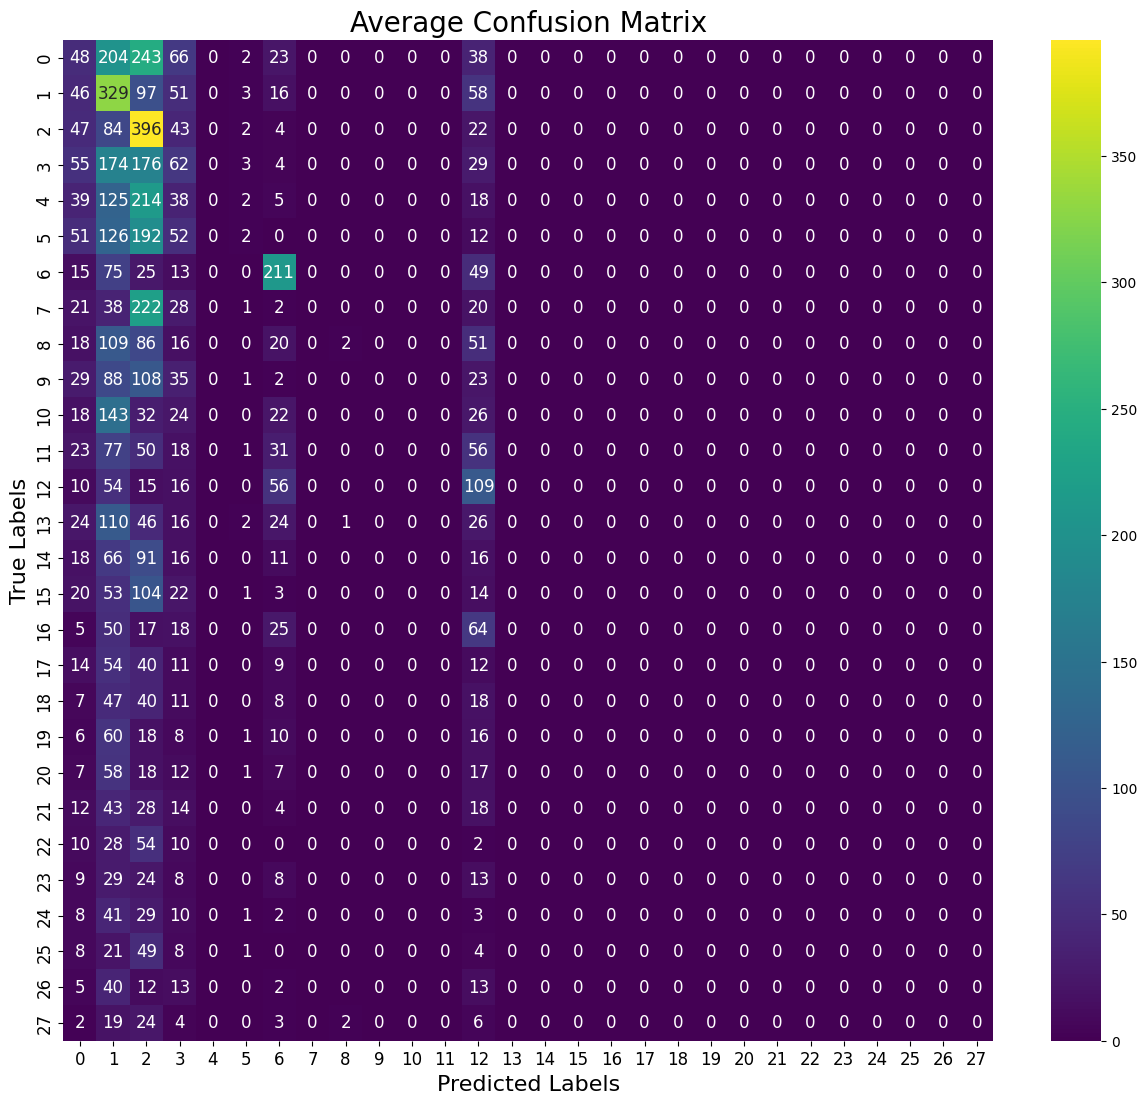

/var/tmp/ipykernel_661204/660891500.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 128)  # Get a color map with enough variations
/var/tmp/ipykernel_661204/660891500.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(epochs, average_accuracies[0], 'k-', color = 'orange',label='Average Training Accuracy', linewidth=2, marker=None, alpha=0.9)


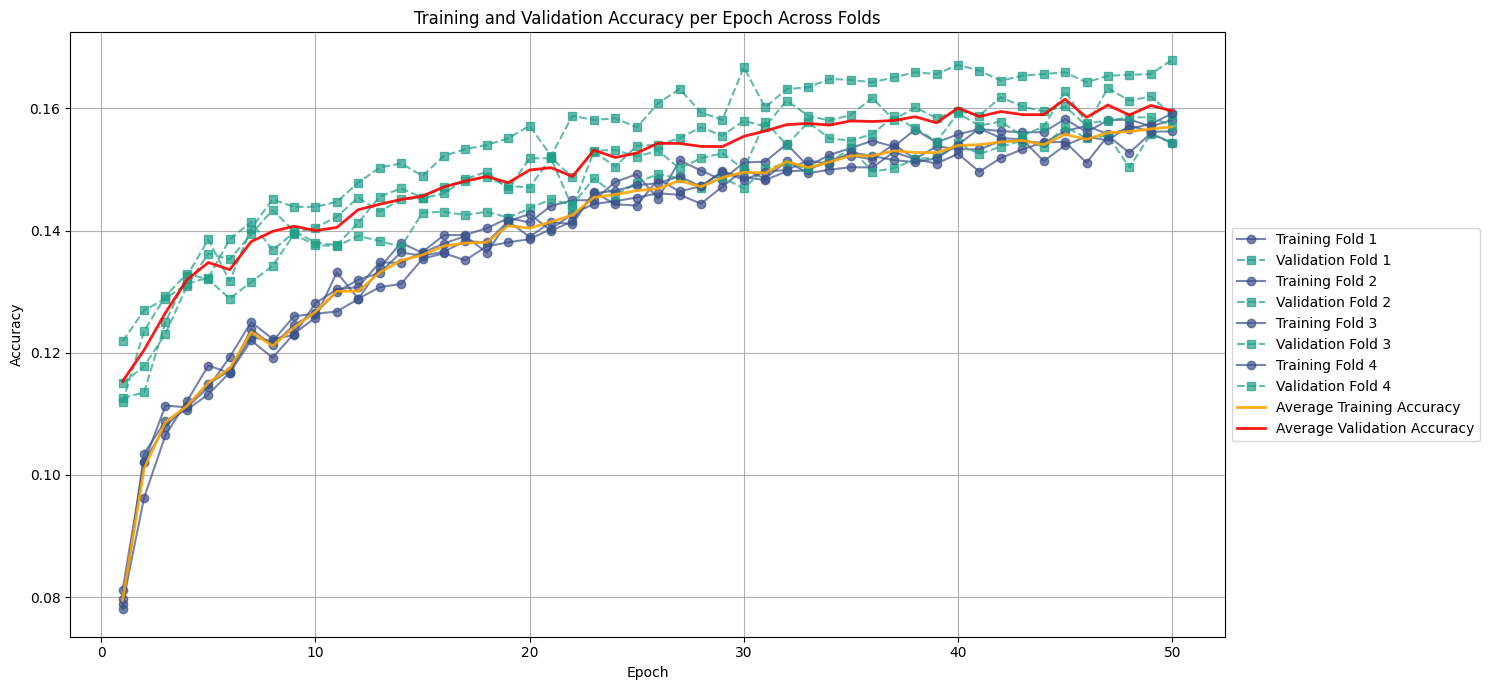

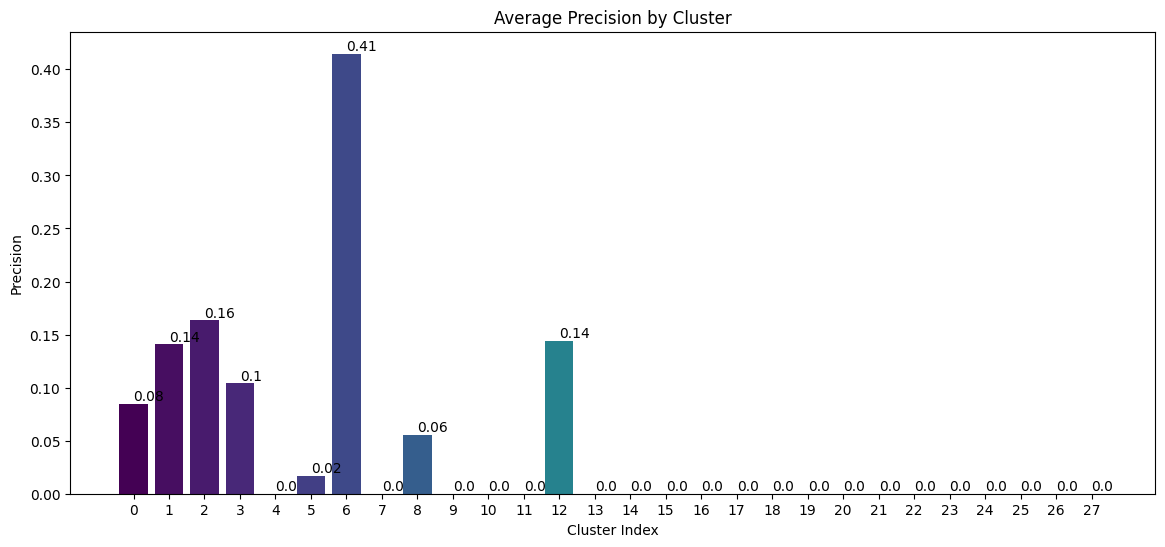

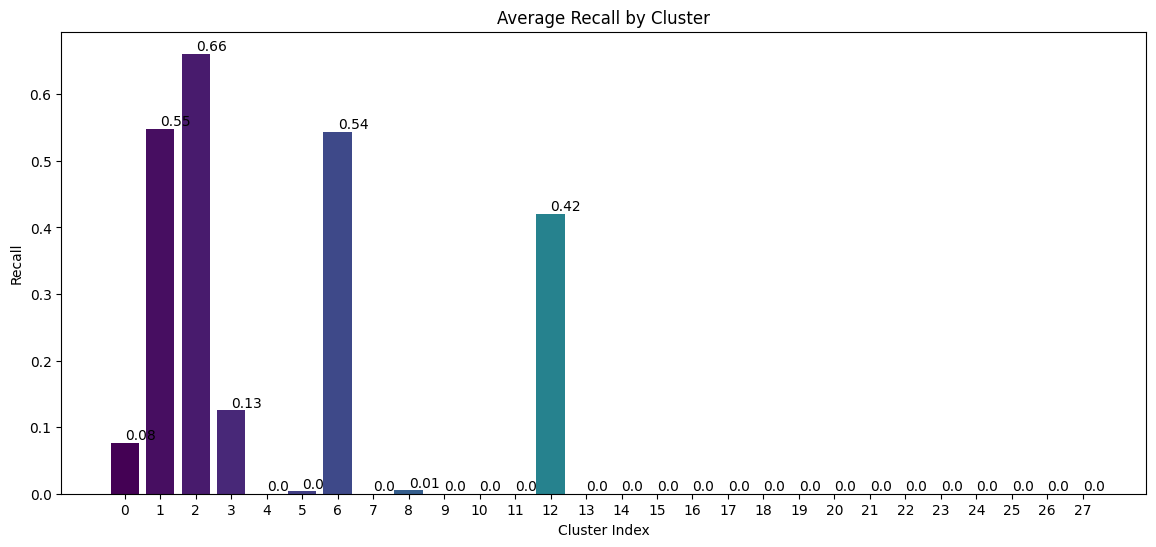

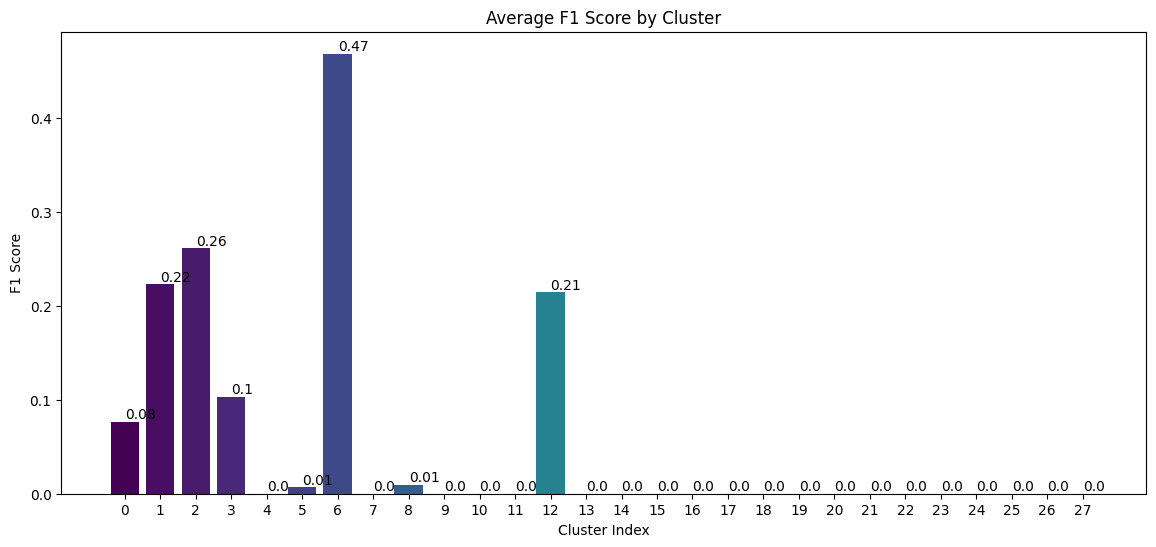

In [ ]:
num_epochs = 70
num_splits = 4
num_repeats = 1
lr_rate = 0.0001
batch_size = 64
folder_path = os.path.join(script_dir, "LabModel")
load_and_visualize_metrics(folder_path, num_folds=num_splits, num_repeats=num_repeats)

Loaded data from /home/jiyu4399/DATA3888_Image_Group_2/ResNet18/Repeat_1_Fold_1/evaluation_metrics.json
Loaded data from /home/jiyu4399/DATA3888_Image_Group_2/ResNet18/Repeat_1_Fold_2/evaluation_metrics.json
Loaded data from /home/jiyu4399/DATA3888_Image_Group_2/ResNet18/Repeat_1_Fold_3/evaluation_metrics.json
Loaded data from /home/jiyu4399/DATA3888_Image_Group_2/ResNet18/Repeat_1_Fold_4/evaluation_metrics.json


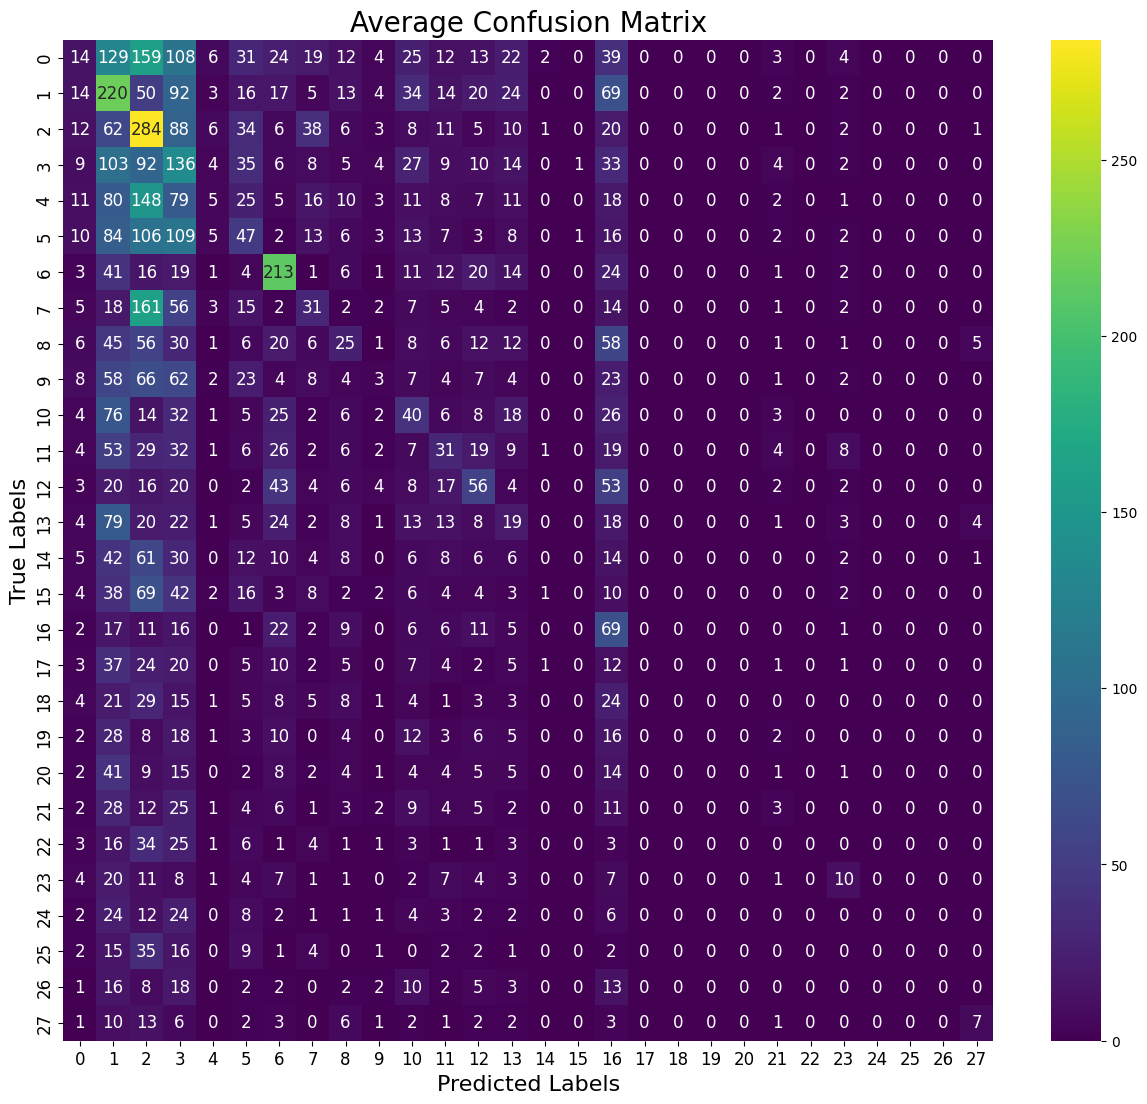

/var/tmp/ipykernel_661204/660891500.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 128)  # Get a color map with enough variations
/var/tmp/ipykernel_661204/660891500.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(epochs, average_accuracies[0], 'k-', color = 'orange',label='Average Training Accuracy', linewidth=2, marker=None, alpha=0.9)


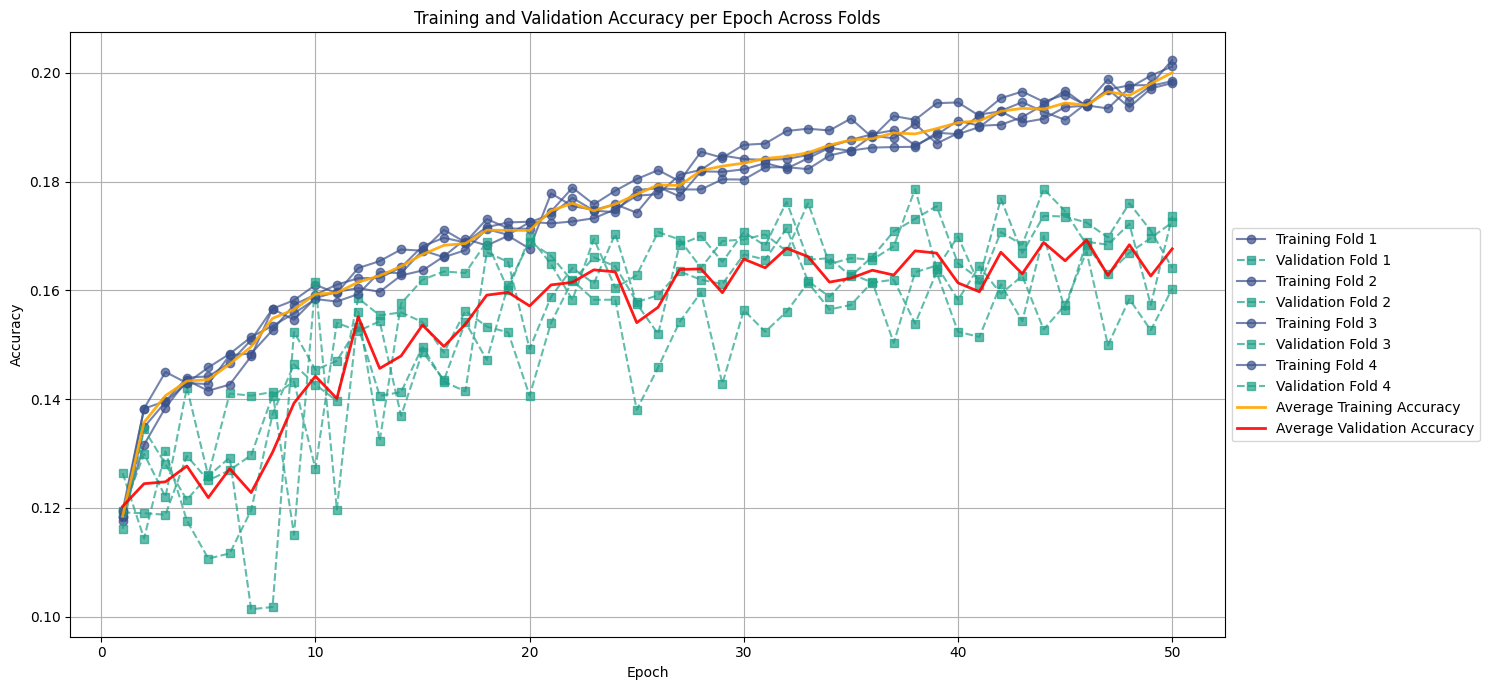

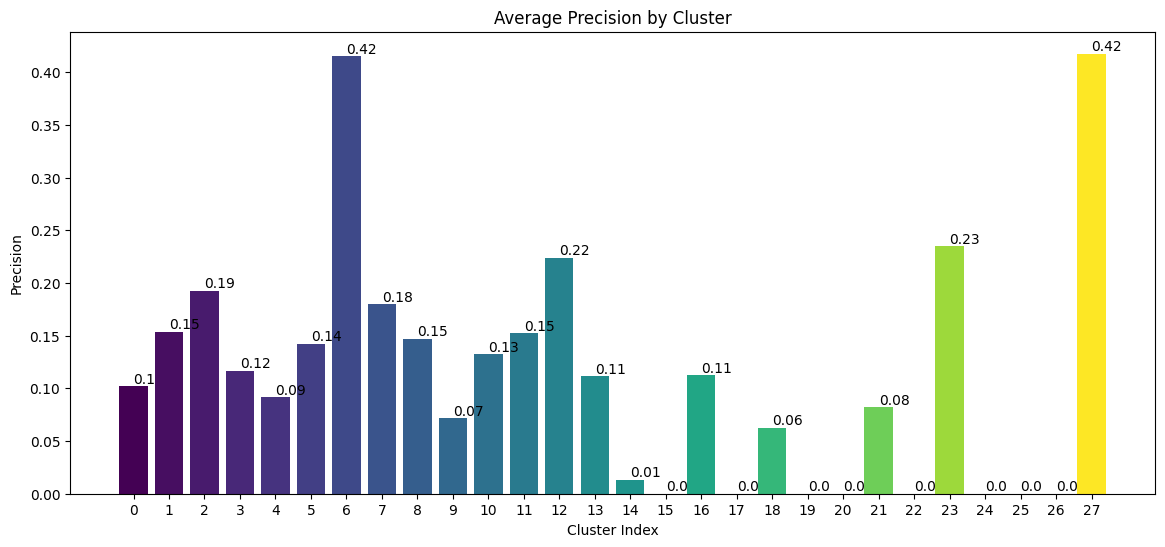

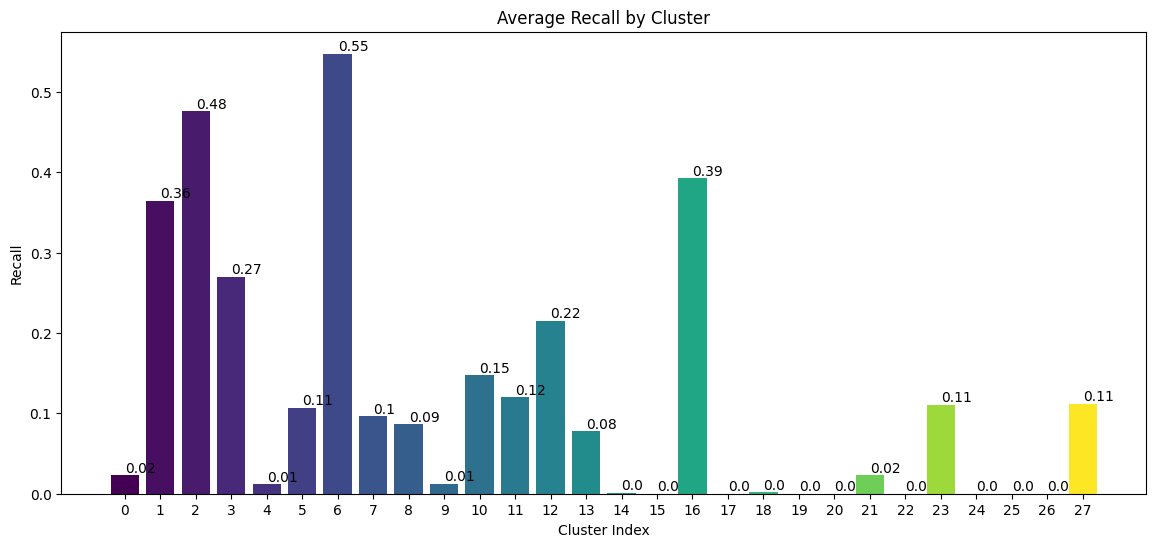

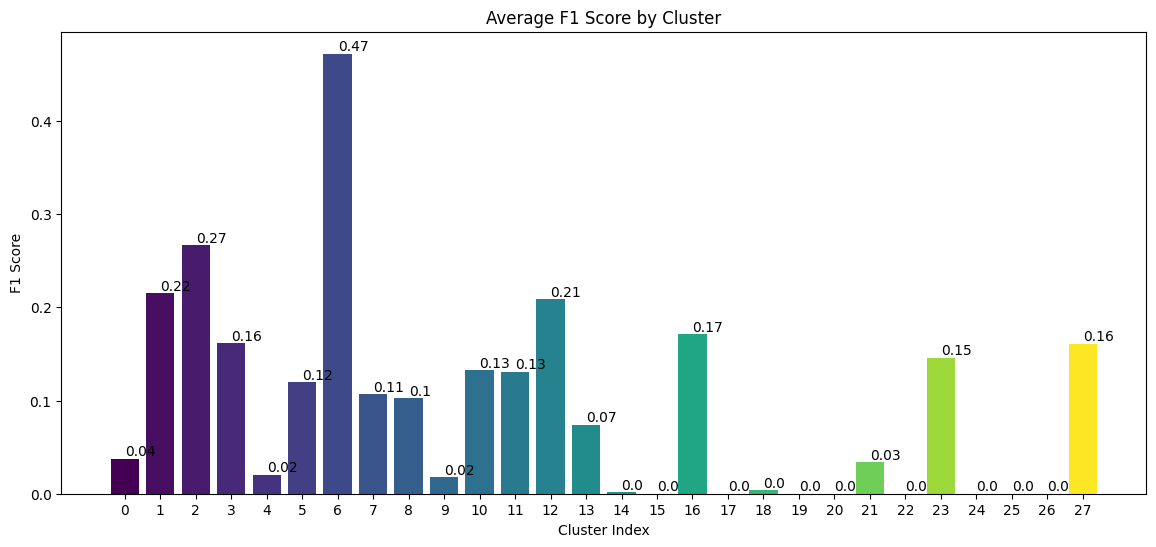

In [ ]:
folder_path = os.path.join(script_dir, "ResNet18")
load_and_visualize_metrics(folder_path, num_folds=num_splits, num_repeats=num_repeats)

Loaded data from /home/jiyu4399/DATA3888_Image_Group_2/ResNet50/Repeat_1_Fold_1/evaluation_metrics.json
Loaded data from /home/jiyu4399/DATA3888_Image_Group_2/ResNet50/Repeat_1_Fold_2/evaluation_metrics.json
Loaded data from /home/jiyu4399/DATA3888_Image_Group_2/ResNet50/Repeat_1_Fold_3/evaluation_metrics.json
Loaded data from /home/jiyu4399/DATA3888_Image_Group_2/ResNet50/Repeat_1_Fold_4/evaluation_metrics.json


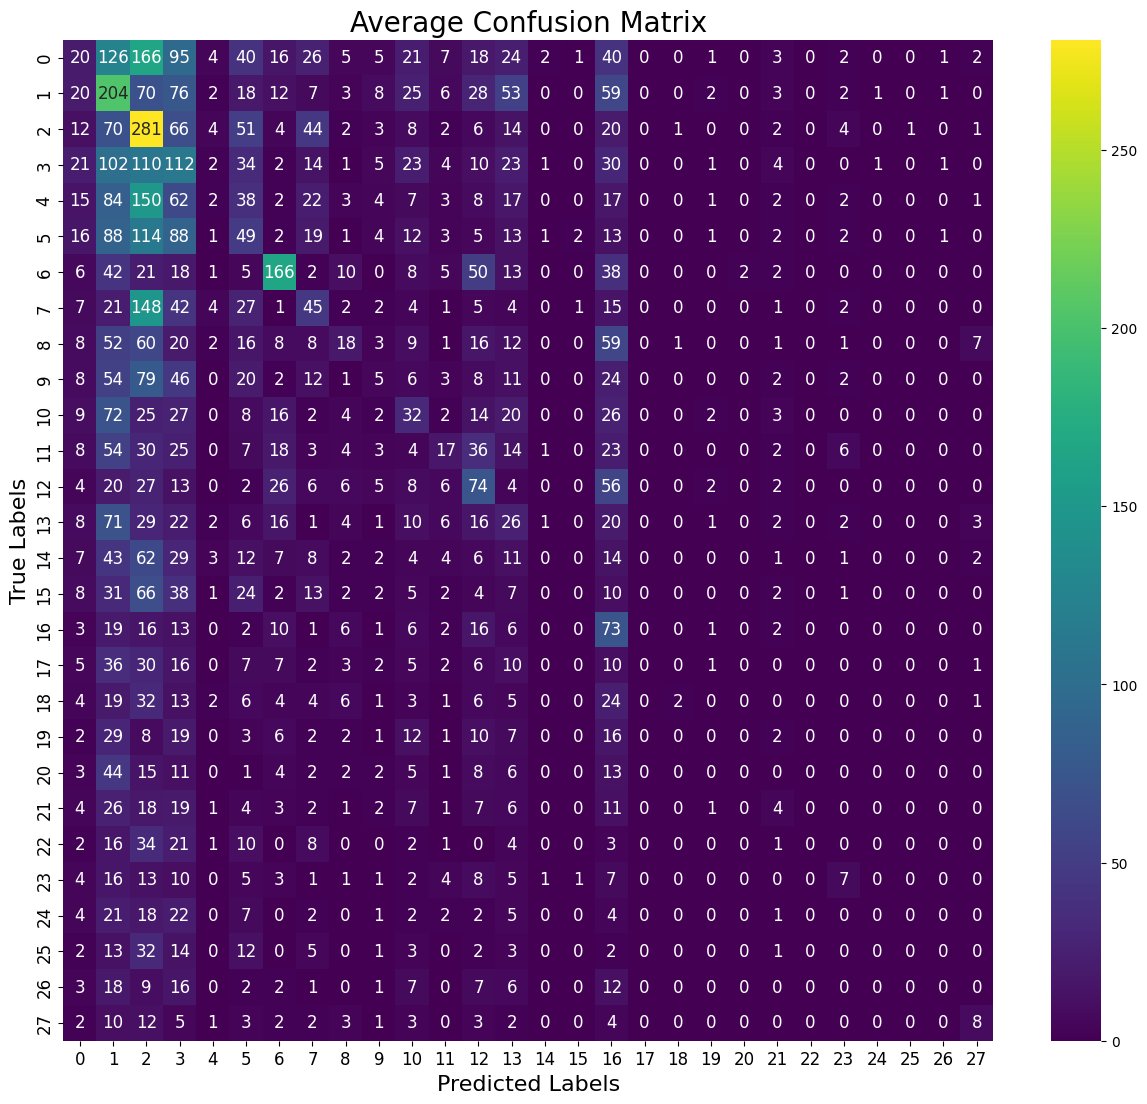

/var/tmp/ipykernel_661204/660891500.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 128)  # Get a color map with enough variations
/var/tmp/ipykernel_661204/660891500.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(epochs, average_accuracies[0], 'k-', color = 'orange',label='Average Training Accuracy', linewidth=2, marker=None, alpha=0.9)


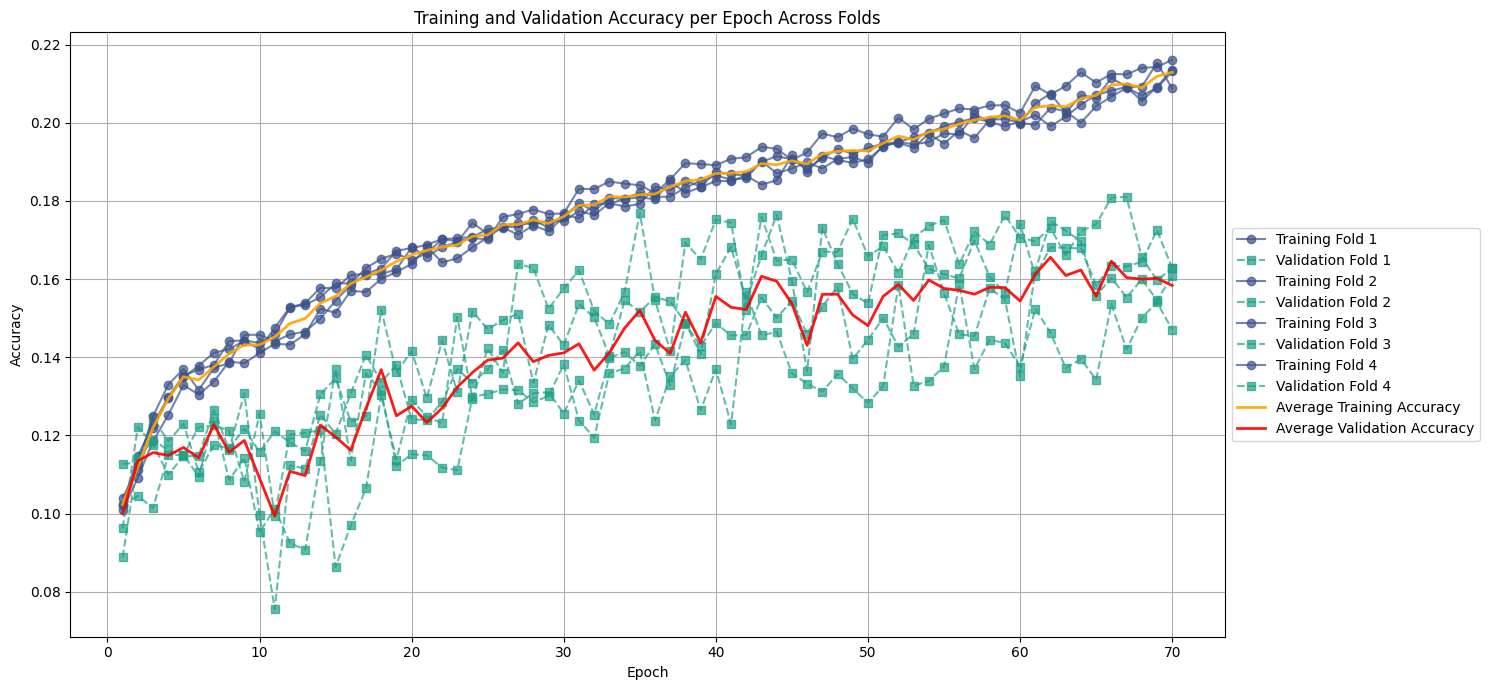

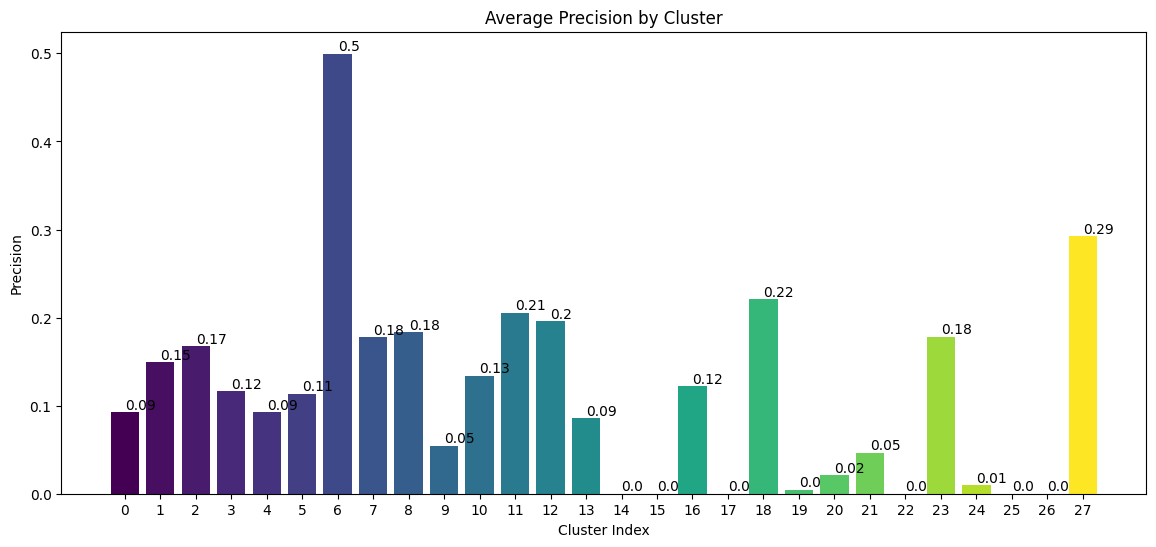

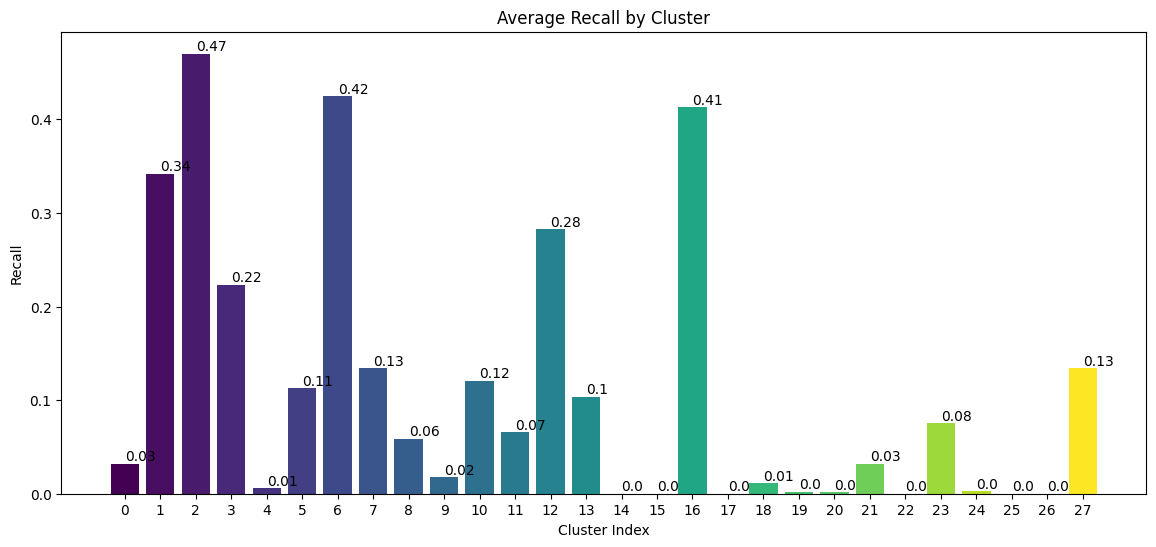

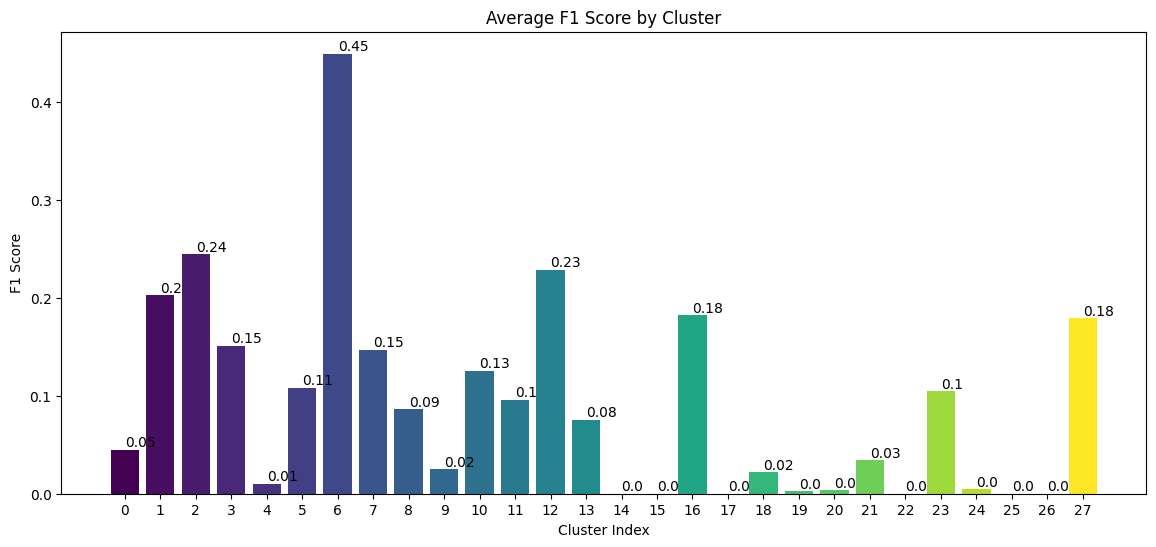

In [ ]:
folder_path = os.path.join(script_dir, "ResNet50")
load_and_visualize_metrics(folder_path, num_folds=num_splits, num_repeats=num_repeats)

In [3]:
from tqdm import tqdm
import torch
import torch.nn as nn


custom_dataset
# Define the sizes of the training, validation, and testing sets
train_size = int(0.6 * len(custom_dataset))  # 60% for training
val_size = int(0.2 * len(custom_dataset))  # 20% for validation
test_size = len(custom_dataset) - train_size - val_size  # Remaining for testing

# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = random_split(
    custom_dataset, [train_size, val_size, test_size]
)

# Define batch size and other DataLoader parameters
batch_size = 64
shuffle = True

# Create DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

# Create DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for testing set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Function to train and evaluate the model
def train_and_evaluate_model(
    ModelClass,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20,
    batch_size=32,
    learning_rate=0.0001,
    save_path=None,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ModelClass().to(device)  # Initialize the model
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss, train_accuracy = perform_training_epoch(
            model, train_loader, optimizer, criterion, device
        )
        val_loss, val_accuracy = perform_validation_epoch(
            model, val_loader, criterion, device
        )

        print(
            f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Acc = {train_accuracy:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_accuracy:.4f}"
        )

        # Optionally save the model at the end of every epoch or only at the end of training
        if save_path:
            model_folder = os.path.join(save_path, f"Epoch_{epoch + 1}")
            if not os.path.exists(model_folder):
                os.makedirs(model_folder)
            torch.save(model.state_dict(), os.path.join(model_folder, "model.pth"))

        # Evaluate on the test set at the end of the training
        if epoch == num_epochs - 1:
            evaluation_metrics = evaluate_model_clusters(model, test_loader)
            if save_path:
                filepath = os.path.join(model_folder, "evaluation_metrics.json")
                save_evaluation_results(evaluation_metrics, filepath)

    return model  # Optionally return the model

NameError: name 'custom_dataset' is not defined

In [1]:
from torch import device, Tensor
import torchvision.models as models


# Load the pre-trained ResNet model
torch.cuda.empty_cache()
model = LabModel
save_path = os.path.join(script_dir, "LabModelTest")

t_loss, v_loss, t_acc, v_acc = train_and_evaluate_model(
    model, train_loader, val_loader, num_epochs=100
)
lab_model_results = {"t_loss": t_loss, "v_loss": v_loss, "t_acc": t_acc, "v_acc": v_acc}

NameError: name 'torch' is not defined